In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import os 
import warnings
import time
import itertools
import dateutil
import datetime
import pyspark
import pyspark.sql.functions

from IPython.core.display import display, HTML, Markdown

display(HTML("<style>.rendered_html { font-size: 17px; }</style>"))
display(HTML("<style>.container { width:100% !important; }</style>"))
warnings.filterwarnings("ignore")



plt.ion()


pd.options.display.min_rows = 200
pd.options.display.max_rows = 200

In [2]:
# nxcals = pytimber.NXCals()
from cern.nxcals.api.extraction.data.builders import DevicePropertyDataQuery, DataQuery 

starttime, endtime = '2021-08-18 06:00:00.000', '2021-08-25 18:00:00.000'

In [3]:
timestamp = lambda date_time : int(datetime.datetime.fromisoformat(date_time).timestamp()*1e9)
day1 = timestamp('2021-08-18 04:00:00'), timestamp('2021-08-18 20:00:00')
day2 = timestamp('2021-08-25 04:00:00'), timestamp('2021-08-25 15:00:00')
day_filter = '(cyclestamp BETWEEN {:} AND {:}) OR (cyclestamp BETWEEN {:} AND {:})'.format(*day1, *day2)
print(day_filter)

(cyclestamp BETWEEN 1629252000000000000 AND 1629309600000000000) OR (cyclestamp BETWEEN 1629856800000000000 AND 1629896400000000000)


In [4]:
pickle_files = [file for file in os.listdir('scanning_script') if 'pckl' in file]

MD entries are [here](https://logbook.cern.ch/elogbook-server/GET/showEventInLogbook/3356023) and [here](https://logbook.cern.ch/elogbook-server/GET/showEventInLogbook/3356058)

special optics (smaller vertical beam at the splitter), scans on beam position and angle at the first splitter
* position scan on scan_2021_08_18_14_28.pckl
* angle scan on scan_2021_08_18_15_01.pckl
* horizontal angle scan_2021_08_18_15_23.pckl
* horizontal angle scan scan_2021_08_18_15_40.pckl

back to regular optics
* scan in vertical position scan_2021_08_18_16_36
* scan in vertical angle scan_2021_08_18_16_56.pckl
* scan of horizontal position scan_2021_08_18_17_18.pckl
* scan of horizontal angle of scan_2021_08_18_17_31.pckl

at 17:35, dynamic trim of the momentum in TT20
* horizontal angle scan_2021_08_18_17_47.pckl left at -1mm
* vertical angle scan at scan_2021_08_18_18_01.pckl

In [5]:
scan = pd.read_pickle('scanning_script/'+pickle_files[0])

### BCT data

In [6]:
df = DevicePropertyDataQuery.builder(spark) \
    .system('CMW').startTime(starttime).endTime(endtime) \
    .entity().device('SPS.BCTDC.51454').property('Acquisition')\
    .build()

bct = df.select('slowExtInt', 'cyclestamp', 'dumpInt', 'selector').filter(day_filter).toPandas()
bct = bct[bct['selector'].str.contains('SFTPRO')]
bct['time'] = pd.to_datetime(bct['cyclestamp'])
bct.set_index('time', inplace=True)

bct['intensity E10'] = bct['slowExtInt'] - bct['dumpInt']
bct.drop(['slowExtInt', 'dumpInt'], inplace=True, axis=1)
all_data = bct
# all_data = all_data[all_data['intensity E10'].between(5, 50)]
all_data.sort_index(inplace=True)

### BLM data

In [7]:
df = DataQuery.builder(spark).byVariables() \
    .system('CMW').startTime(starttime).endTime(endtime) \
    .variableLike('SP.BLML.2%:beamLosses_gray')\
    .build()
blms = df.select('nxcals_value', 'nxcals_timestamp', 'nxcals_variable_name').filter(day_filter).toPandas()
blms['nxcals_timestamp'] = pd.to_datetime(blms['nxcals_timestamp'])
blms.set_index('nxcals_timestamp', inplace=True)

In [8]:
relevant_blms = [
 'SP.BLML.211631.LLS_MDLV_TDC2:beamLosses_gray',
 'SP.BLML.211708.LLS_TCSC_TDC2:beamLosses_gray',
 'SP.BLML.211713.LLS_MSSB_TDC2:beamLosses_gray',
 'SP.BLML.211714.RLS_MSSB_TDC2:beamLosses_gray',
 'SP.BLML.211732.LLS_MSSB_TDC2:beamLosses_gray',
 'SP.BLML.211741.LLS_MSSB_TDC2:beamLosses_gray',
 'SP.BLML.211742.RLS_MSSB_TDC2:beamLosses_gray',
 'SP.BLML.220400.LLS_QTAD_TDC2:beamLosses_gray',
 'SP.BLML.220436.LLS_TSCS_TDC2:beamLosses_gray',
 'SP.BLML.220441.LLS_MSSB_TDC2:beamLosses_gray',
 'SP.BLML.220442.RLS_MSSB_TDC2:beamLosses_gray',
 'SP.BLML.220460.LLS_MSSB_TDC2:beamLosses_gray',
 'SP.BLML.220469.LLS_MSSB_TDC2:beamLosses_gray',
 'SP.BLML.240209.LLS_MDLV_TDC2:beamLosses_gray'
]

In [9]:
def get_vals_for_this_time(row, variable_names, input_frame, time_window_seconds = 3):
    df = input_frame.between_time((row.name-pd.to_timedelta(time_window_seconds, unit='s')).time(), 
                                  (row.name+pd.to_timedelta(time_window_seconds, unit='s')).time())
    vals = []
    for var in variable_names:
        df1 = df[df['nxcals_variable_name']==var]
        if len(df1) > 1:
            print('warning, more than one, length is ', len(df1), var, row.name)
            val = df1.iloc[0]['nxcals_value']
        elif len(df1) == 0:
            print('warning, no data for', var, row.name)
            val = 0 
        else:
            val = df1.iloc[0]['nxcals_value']
        vals.append(val)
    return vals
        
                
    

In [10]:
all_data[relevant_blms] = all_data.apply(lambda row : get_vals_for_this_time(row,relevant_blms, blms.loc[row.name.date().isoformat()]) , axis=1, result_type='expand')


In [11]:
renaming = {
 'SP.BLML.211631.LLS_MDLV_TDC2:beamLosses_gray': 'BLM 211631.LLS_MDLV',
 'SP.BLML.211708.LLS_TCSC_TDC2:beamLosses_gray': 'BLM 211708.LLS_TCSC',
 'SP.BLML.211713.LLS_MSSB_TDC2:beamLosses_gray': 'BLM 211713.LLS_MSSB',
 'SP.BLML.211714.RLS_MSSB_TDC2:beamLosses_gray': 'BLM 211714.RLS_MSSB',
 'SP.BLML.211732.LLS_MSSB_TDC2:beamLosses_gray': 'BLM 211732.LLS_MSSB',
 'SP.BLML.211741.LLS_MSSB_TDC2:beamLosses_gray': 'BLM 211741.LLS_MSSB',
 'SP.BLML.211742.RLS_MSSB_TDC2:beamLosses_gray': 'BLM 211742.RLS_MSSB',
 'SP.BLML.220400.LLS_QTAD_TDC2:beamLosses_gray': 'BLM 220400.LLS_QTAD',
 'SP.BLML.220436.LLS_TSCS_TDC2:beamLosses_gray': 'BLM 220436.LLS_TSCS',
 'SP.BLML.220441.LLS_MSSB_TDC2:beamLosses_gray': 'BLM 220441.LLS_MSSB',
 'SP.BLML.220442.RLS_MSSB_TDC2:beamLosses_gray': 'BLM 220442.RLS_MSSB',
 'SP.BLML.220460.LLS_MSSB_TDC2:beamLosses_gray': 'BLM 220460.LLS_MSSB',
 'SP.BLML.220469.LLS_MSSB_TDC2:beamLosses_gray': 'BLM 220469.LLS_MSSB',
 'SP.BLML.240209.LLS_MDLV_TDC2:beamLosses_gray': 'BLM 240209.LLS_MDLV'
}
all_data.rename(columns=renaming, inplace=True)

In [247]:
all_blms = ['BLM 211631.LLS_MDLV', 'BLM 211708.LLS_TCSC', 'BLM 211713.LLS_MSSB', 'BLM 211714.RLS_MSSB', 'BLM 211732.LLS_MSSB', 'BLM 211741.LLS_MSSB', 'BLM 211742.RLS_MSSB',
 'BLM 220400.LLS_QTAD', 'BLM 220436.LLS_TSCS', 'BLM 220441.LLS_MSSB', 'BLM 220442.RLS_MSSB', 'BLM 220460.LLS_MSSB', 'BLM 220469.LLS_MSSB', 'BLM 240209.LLS_MDLV']

blms_MSSB1 = ['BLM 211708.LLS_TCSC', 'BLM 211713.LLS_MSSB', 'BLM 211714.RLS_MSSB', 'BLM 211732.LLS_MSSB', 'BLM 211741.LLS_MSSB', 'BLM 211742.RLS_MSSB']

blms_MSSB2 = ['BLM 220436.LLS_TSCS', 'BLM 220441.LLS_MSSB', 'BLM 220442.RLS_MSSB', 'BLM 220460.LLS_MSSB', 'BLM 220469.LLS_MSSB']

all_data['blms MSSB1'] = all_data[blms_MSSB1].sum(axis=1)
all_data['blms MSSB2'] = all_data[blms_MSSB2].sum(axis=1)
all_data['blms'] = all_data[all_blms].sum(axis=1)

### Power supplies data

In [13]:
power_supplies = [
    'RPPAX.BA2.MDLV.2115:LOG.I.MEAS:value',
    'RPPAV.BA80.MDLV.2116:LOG.I.MEAS:value',
    'RPPAD.BA80.MDLV.2201.M:LOG.I.MEAS:value',
    'RPPAD.BA80.MDLV.2204.M:LOG.I.MEAS:value',
    'RPPCK.BA2.MBE.2103.M:LOG.I.MEAS:value',
    'RPPAW.BA2.MPLS.2115:LOG.I.MEAS:value',
    'RPPBJ.BA80.MDAH.2201:LOG.I.MEAS:value',
    'RPPBJ.BA80.MDAH.2303:LOG.I.MEAS:value',
    'RPPCG.BA2.SBYH.2113:LOG.I.MEAS:value',
    'RPPAD.BA80.MDAV.2305.M:LOG.I.MEAS:value',
    'RPPAC.BA80.MDAV.2301.M:LOG.I.MEAS:value'
]

df = DataQuery.builder(spark).byVariables() \
.system('CMW').startTime(starttime).endTime(endtime) \
.variable('RPPAX.BA2.MDLV.2115:LOG.I.MEAS:value')\
.variable('RPPAV.BA80.MDLV.2116:LOG.I.MEAS:value')\
.variable('RPPAD.BA80.MDLV.2201.M:LOG.I.MEAS:value')\
.variable('RPPAD.BA80.MDLV.2204.M:LOG.I.MEAS:value')\
.variable('RPPCK.BA2.MBE.2103.M:LOG.I.MEAS:value')\
.variable('RPPAW.BA2.MPLS.2115:LOG.I.MEAS:value')\
.variable('RPPBJ.BA80.MDAH.2201:LOG.I.MEAS:value')\
.variable('RPPBJ.BA80.MDAH.2303:LOG.I.MEAS:value')\
.variable('RPPCG.BA2.SBYH.2113:LOG.I.MEAS:value')\
.variable('RPPAD.BA80.MDAV.2305.M:LOG.I.MEAS:value')\
.variable('RPPAC.BA80.MDAV.2301.M:LOG.I.MEAS:value')\
.build()


def average_current(current_dic):
    mean = np.mean(current_dic['elements'][4000:8000])
    return np.float(mean)
udf_function = pyspark.sql.functions.udf(average_current, 
                                         pyspark.sql.types.DoubleType())

new_df = df.withColumn(
    'average current', 
    udf_function(pyspark.sql.functions.col('nxcals_value'))
)

magnets = new_df.select('average current', 'nxcals_timestamp', 'nxcals_variable_name').filter(day_filter).toPandas()
magnets['nxcals_timestamp'] = pd.to_datetime(magnets['nxcals_timestamp'])
magnets.set_index('nxcals_timestamp', inplace=True)
magnets['nxcals_value'] = magnets['average current']

In [14]:

all_data[power_supplies] = all_data.apply(lambda row : get_vals_for_this_time(row,power_supplies, magnets.loc[row.name.date().isoformat()], time_window_seconds = 5) , axis=1, result_type='expand')


In [15]:
renaming = {
    'RPPAX.BA2.MDLV.2115:LOG.I.MEAS:value':'MDLV.2115', 
    'RPPAV.BA80.MDLV.2116:LOG.I.MEAS:value': 'MDLV.2116',
    'RPPAD.BA80.MDLV.2201.M:LOG.I.MEAS:value': 'MDLV.2201',
    'RPPAD.BA80.MDLV.2204.M:LOG.I.MEAS:value': 'MDLV.2204',
    'RPPCK.BA2.MBE.2103.M:LOG.I.MEAS:value': 'MBE.2103',
    'RPPAW.BA2.MPLS.2115:LOG.I.MEAS:value': 'MPLS.2115',
    'RPPBJ.BA80.MDAH.2201:LOG.I.MEAS:value': 'MDAH.2201',
    'RPPBJ.BA80.MDAH.2303:LOG.I.MEAS:value': 'MDAH.2303',
    'RPPCG.BA2.SBYH.2113:LOG.I.MEAS:value':'MBB.2113',
    'RPPAD.BA80.MDAV.2305.M:LOG.I.MEAS:value':'MDAV.2305',
    'RPPAC.BA80.MDAV.2301.M:LOG.I.MEAS:value':'MDAV.2301'

}
all_data.rename(columns=renaming, inplace=True)

#### magnets calibration

In [16]:
Boro = 400*3.3356410

#MDLVs 
calib = pd.read_csv('MDLV.csv', skiprows=2, names=['BL', 'I'])
calib['theta'] = calib['BL']/Boro

for col in ['MDLV.2115', 'MDLV.2116', 'MDLV.2201', 'MDLV.2204']:
    all_data[col+'/K'] = np.interp(all_data[col], calib['I'], calib['theta'])
    
    
#MBE
calib = pd.read_csv('MBE.csv', skiprows=2, names=['BL', 'I'])
calib['theta'] = calib['BL']/Boro
all_data['MBB.2113'+'/K'] = np.interp(all_data['MBE.2103']+all_data['MBB.2113'], calib['I'], calib['theta'])

#MPLS
calib = pd.read_csv('MPLS.csv', skiprows=2, names=['BL', 'I'])
calib['theta'] = calib['BL']/Boro
all_data['MPLS.2115'+'/K'] = np.interp(all_data['MPLS.2115'], calib['I'], calib['theta'])

#MDAH
calib = pd.read_csv('MDA.csv', skiprows=2, names=['BL', 'I'])
calib['theta'] = calib['BL']/Boro
all_data['MDAH.2201'+'/K'] = np.interp(all_data['MDAH.2201'], calib['I'], calib['theta'])
all_data['MDAH.2303'+'/K'] = np.interp(all_data['MDAH.2303'], calib['I'], calib['theta'])
all_data['MDAV.2305'+'/K'] = np.interp(all_data['MDAV.2305'], calib['I'], calib['theta'])
all_data['MDAV.2301'+'/K'] = np.interp(all_data['MDAV.2301'], calib['I'], calib['theta'])


### BSI data

List of important BSIs
 * t2, t4 and t6 targets respectively BSI.230705
 * in TT21 : 
 * downstream of splitter 1

In [17]:
bsi_names = [
    'BBSH.21638', 'BBSH.21691', 'BBSV.21691', 'BBSH.210025', 'BBSV.210025', 'BBSH.210276', 'BBSV.210276', 
    'BBSH.210509', 'BBSH.21636', 'BBSH.21631', 'BBSV.21631', 'BBSH.21876', 'BBSV.21876', 'BBSH.21758', 
    'BBSH.21773', 'BBSV.21773', 'BBSH.21778', 'BBSV.21798', 'BSIA.210279', 'BSIB.210279', 'BSIA.210272', 
    'BSIB.210272', 'BSIC.210272', 'BSID.210272', 'BSIA.210278', 'BSIB.210278', 'BSIC.210278', 'BSID.210278', 
    'BSH.230949', 'BSV.230949', 'BSI.230949', 'BSH.230950', 'BSV.230950', 'BSI.230950', 'BBSTH.230949', 'BBSTV.230949', 
    'BSHS.241149', 'BSVS.241149', 'BSI.241149', 'BSHS.241150', 'BSI.241150', 'BBSTH.241150', 'BBSTV.241150', 'BSHS.251247', 
    'BSVS.251247', 'BSI.251247', 'BSHS.251248', 'BSVS.251248', 'BSI.251248', 'BBSH.251245', 'BBSV.251245', 'BSI.230705', 
    'BSI.240610', 'BSI.251010', 'BSI.211626', 'BSIA.220412', 'BBSH.043166', 'BBSV.043166', 'BSI.043282', 'BSI.045769', 
    'T10-BSI.045914', 'T10-BSHS.045914', 'T10-BSVS.045914', 'T10-BBSTH.045914', 'T10-BBSTV.045914', 'BBSH.043224', 
    'BBSV.043224', 'BBSH.043281', 'BBSV.043281'
]
print('bsi for t2 ', bsi_names[51])
print('bsi for t4 ', bsi_names[52])
print('bsi for t6 ', bsi_names[53])

working_bsis = ['BBSH.21773', 'BBSV.21773', 'BSIA.210279', 'BSIB.210279', 'BSIA.210278', 'BSIB.210278', 'BSIC.210278', 
                'BSID.210278', 'BSI.230949', 'BSH.230950', 'BSV.230950', 'BSI.230950', 'BSHS.241150', 'BSI.241150', 
                'BSI.251247', 'BSHS.251248', 'BSVS.251248', 'BSI.251248', 'BSI.230705', 'BSI.240610', 'BSI.211626', 'BSI.251010',
                'BSIA.220412', 'BSI.043282', 'BSI.045769', 'T10-BSI.045914', 'T10-BSVS.045914']



# only_bsis = [monitor for monitor in bsi_names if 'BSI.' in  monitor and 'T10' not in monitor]

bsi for t2  BSI.230705
bsi for t4  BSI.240610
bsi for t6  BSI.251010


In [18]:
df = DevicePropertyDataQuery.builder(spark) \
    .system('CMW').startTime(starttime).endTime(endtime) \
    .entity().device('SEM_CONCENTRATOR_TT20').property('BeamIntensity')\
    .build()

bsis = df.select('cyclestamp', 'intensity', 'intensity_adc_raw', 'selector').filter(day_filter).toPandas()
bsis['cyclestamp'] = pd.to_datetime(bsis['cyclestamp'])
bsis.set_index('cyclestamp', inplace=True)

In [19]:
def recompute_intensity(adc):
    baseline = adc[:30].mean()

    adc_offseted = adc - baseline
    adc_offseted *= np.sign(adc_offseted.sum())

    masked_adc = np.ma.masked_where(adc_offseted<0, adc_offseted)
    masked_adc[-20:] = np.ma.masked

    summed_signal = masked_adc.sum()
    return summed_signal, adc

for bsi_name in bsi_names:
    bsis[bsi_name] = bsis.apply(lambda row: row['intensity']['elements'][bsi_names.index(bsi_name)], axis=1)
    bsis[[bsi_name + ' recomputed', bsi_name + ' adc']] = bsis.apply(
        lambda row: recompute_intensity(row['intensity_adc_raw']['elements']\
                                        .reshape(row['intensity_adc_raw']['dimensions'])[:, bsi_names.index(bsi_name)]), 
        axis=1, result_type='expand')

In [20]:
def get_vals(row, variable_names, input_frame, time_window_seconds = 2):
    df = input_frame.between_time((row.name-pd.to_timedelta(time_window_seconds, unit='s')).time(), 
                                  (row.name+pd.to_timedelta(time_window_seconds, unit='s')).time())
    vals = []
    for var in variable_names:
        if len(df) > 1:
            print('warning, more than one, length is ', len(df), var, row.name)
            val = df.iloc[0]['nxcals_value']
        elif len(df) == 0:
            print('warning, no data for', var, row.name)
            val = 0 
        else:
            val = df.iloc[0][var]
        vals.append(val)
    return vals
        
all_data[bsi_names] = all_data.apply(lambda row : get_vals(row,bsi_names, bsis.loc[row.name.date().isoformat()], time_window_seconds = 5) , axis=1, result_type='expand')

recomputed_bsis = [bsi_name + ' recomputed' for bsi_name in bsi_names]
all_data[recomputed_bsis] = all_data.apply(lambda row : get_vals(row,recomputed_bsis, bsis.loc[row.name.date().isoformat()], time_window_seconds = 5) , axis=1, result_type='expand')


warning, no data for BBSH.21638 2021-08-25 07:14:07.335000
warning, no data for BBSH.21691 2021-08-25 07:14:07.335000
warning, no data for BBSV.21691 2021-08-25 07:14:07.335000
warning, no data for BBSH.210025 2021-08-25 07:14:07.335000
warning, no data for BBSV.210025 2021-08-25 07:14:07.335000
warning, no data for BBSH.210276 2021-08-25 07:14:07.335000
warning, no data for BBSV.210276 2021-08-25 07:14:07.335000
warning, no data for BBSH.210509 2021-08-25 07:14:07.335000
warning, no data for BBSH.21636 2021-08-25 07:14:07.335000
warning, no data for BBSH.21631 2021-08-25 07:14:07.335000
warning, no data for BBSV.21631 2021-08-25 07:14:07.335000
warning, no data for BBSH.21876 2021-08-25 07:14:07.335000
warning, no data for BBSV.21876 2021-08-25 07:14:07.335000
warning, no data for BBSH.21758 2021-08-25 07:14:07.335000
warning, no data for BBSH.21773 2021-08-25 07:14:07.335000
warning, no data for BBSV.21773 2021-08-25 07:14:07.335000
warning, no data for BBSH.21778 2021-08-25 07:14:07

warning, no data for BBSH.21638 recomputed 2021-08-25 07:14:07.335000
warning, no data for BBSH.21691 recomputed 2021-08-25 07:14:07.335000
warning, no data for BBSV.21691 recomputed 2021-08-25 07:14:07.335000
warning, no data for BBSH.210025 recomputed 2021-08-25 07:14:07.335000
warning, no data for BBSV.210025 recomputed 2021-08-25 07:14:07.335000
warning, no data for BBSH.210276 recomputed 2021-08-25 07:14:07.335000
warning, no data for BBSV.210276 recomputed 2021-08-25 07:14:07.335000
warning, no data for BBSH.210509 recomputed 2021-08-25 07:14:07.335000
warning, no data for BBSH.21636 recomputed 2021-08-25 07:14:07.335000
warning, no data for BBSH.21631 recomputed 2021-08-25 07:14:07.335000
warning, no data for BBSV.21631 recomputed 2021-08-25 07:14:07.335000
warning, no data for BBSH.21876 recomputed 2021-08-25 07:14:07.335000
warning, no data for BBSV.21876 recomputed 2021-08-25 07:14:07.335000
warning, no data for BBSH.21758 recomputed 2021-08-25 07:14:07.335000
warning, no dat

In [248]:
all_data_all_time = all_data

# MD 18/08

In [249]:

all_data = all_data_all_time.loc['2021-08-18']

In [250]:
all_scans = {}

## smaller V beam

### Y scan

In [251]:
k_names = ['MDLV.2115/K', 'MDLV.2116/K', 'MDLV.2201/K', 'MDLV.2204/K', 'MBB.2113/K', 'MPLS.2115/K', 'MDAH.2201/K', 'MDAH.2303/K']
default_strength = all_data[k_names].between_time('12:32', '12:33').mean().to_dict()
all_data[k_names].between_time('12:32', '12:33').std()

MDLV.2115/K    1.133835e-09
MDLV.2116/K    9.162024e-10
MDLV.2201/K    1.224915e-09
MDLV.2204/K    1.229755e-09
MBB.2113/K     5.068487e-09
MPLS.2115/K    3.585761e-10
MDAH.2201/K    1.159869e-09
MDAH.2303/K    4.231951e-10
dtype: float64

In [252]:
# scan on vertical position, smaller V optics
knob = {'MDLV.2115/K': 10.36e-6,
        'MDLV.2116/K': 4.44e-6,
        'MDLV.2201/K': -12.51e-6,
    'MDLV.2204/K': 11.46e-6,
}

def knob_values(row, knob):
    knob_values = []
    for key in knob:
        val = (row[key]-default_strength[key])/knob[key]
        knob_values.append(val)
    knob_values = np.array(knob_values)
    return knob_values, knob_values.mean(), knob_values.std()

all_data[['knob', 'knob mean', 'knob std']] = all_data[k_names].apply(lambda row: knob_values(row, knob), axis=1, result_type='expand')

# df_scan = all_data[(all_data['knob std']<0.8) & (np.abs(all_data['knob mean'])>2)]
df_scan = all_data.between_time('12:11:30', '12:32')
df_scan[['knob', 'knob mean', 'knob std', 'selector', 'intensity E10']]
df_scan = df_scan[df_scan['intensity E10'].between(10, 100)]
all_scans['18 smallerV y'] = df_scan

(-14.998888485788202, 22.69743859813508)

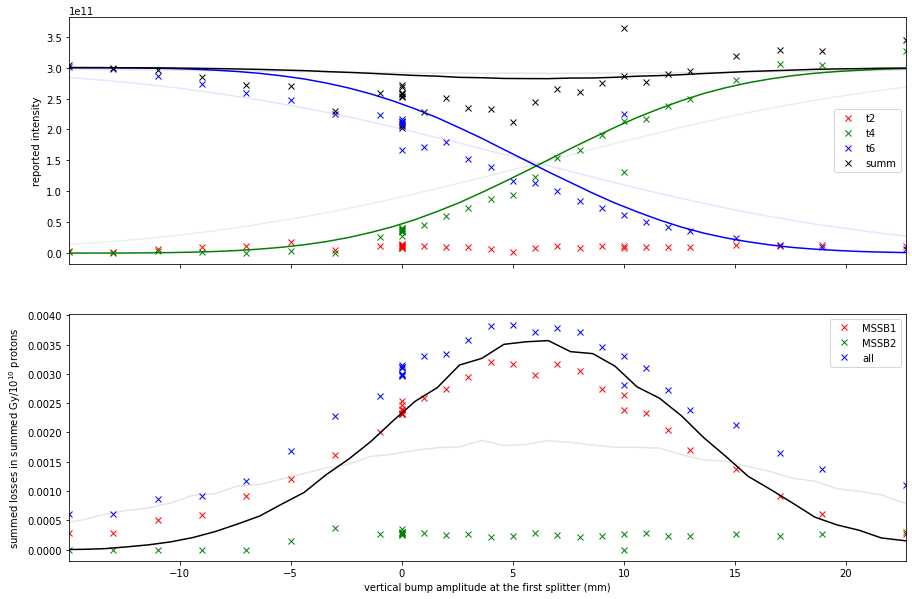

In [254]:
fig, axs = plt.subplots(2, 1, figsize=(15, 10), sharex=True)

axs[1].set_xlabel('vertical bump amplitude at the first splitter (mm)')

t2 = 'BSI.230705'
t4 = 'BSI.240610'
t6 = 'BSI.251010'

ax = axs[0]
ax.plot(df_scan['knob mean'], df_scan[t2], 'rx', label='t2')
ax.plot(df_scan['knob mean'], df_scan[t4], 'gx', label='t4')
ax.plot(df_scan['knob mean'], df_scan[t6], 'bx', label='t6')
ax.plot(df_scan['knob mean'], df_scan[t2]+df_scan[t4]+df_scan[t6], 'kx', label='summ')
ax.legend()
ax.set_ylabel('reported intensity')

df_model = pd.read_pickle('efficiency_positions_y.pckl')
# ax = ax.twinx()
Vscale, Xoffset = 3e11, 5.6
ax.plot(df_model['positions']*1e3+Xoffset, df_model['smallerV top']*Vscale, 'g-')
ax.plot(df_model['positions']*1e3+Xoffset, df_model['smallerV bottom']*Vscale, 'b-')
ax.plot(df_model['positions']*1e3+Xoffset, (1-df_model['smallerV lost'])*Vscale, 'k-')


ax.plot(df_model['positions']*1e3+Xoffset, df_model['nominal top']*Vscale, 'g-', alpha=0.1)
ax.plot(df_model['positions']*1e3+Xoffset, df_model['nominal bottom']*Vscale, 'b-', alpha=0.1)
ax.plot(df_model['positions']*1e3+Xoffset, (1-df_model['nominal lost'])*Vscale, 'k-', alpha=0.1)


ax.set_xlim(df_scan['knob mean'].min(), df_scan['knob mean'].max())


ax = axs[1]
ax.set_ylabel('summed losses in summed Gy/10$^{10}$ protons')
ax.plot(df_scan['knob mean'], df_scan['blms MSSB1']/df_scan['intensity E10'], 'rx', label='MSSB1')
ax.plot(df_scan['knob mean'], df_scan['blms MSSB2']/df_scan['intensity E10'], 'gx', label='MSSB2')
ax.plot(df_scan['knob mean'], df_scan['blms']/df_scan['intensity E10'], 'bx', label='all')
ax.legend()

df_model = pd.read_pickle('efficiency_positions_y.pckl')
# ax = ax.twinx()
Vscale, Xoffset = 0.06, 5.6
ax.plot(df_model['positions']*1e3+Xoffset, (df_model['smallerV lost'])*Vscale, 'k-')


ax.plot(df_model['positions']*1e3+Xoffset, (df_model['nominal lost'])*Vscale, 'k-', alpha=0.1)


ax.set_xlim(df_scan['knob mean'].min(), df_scan['knob mean'].max())



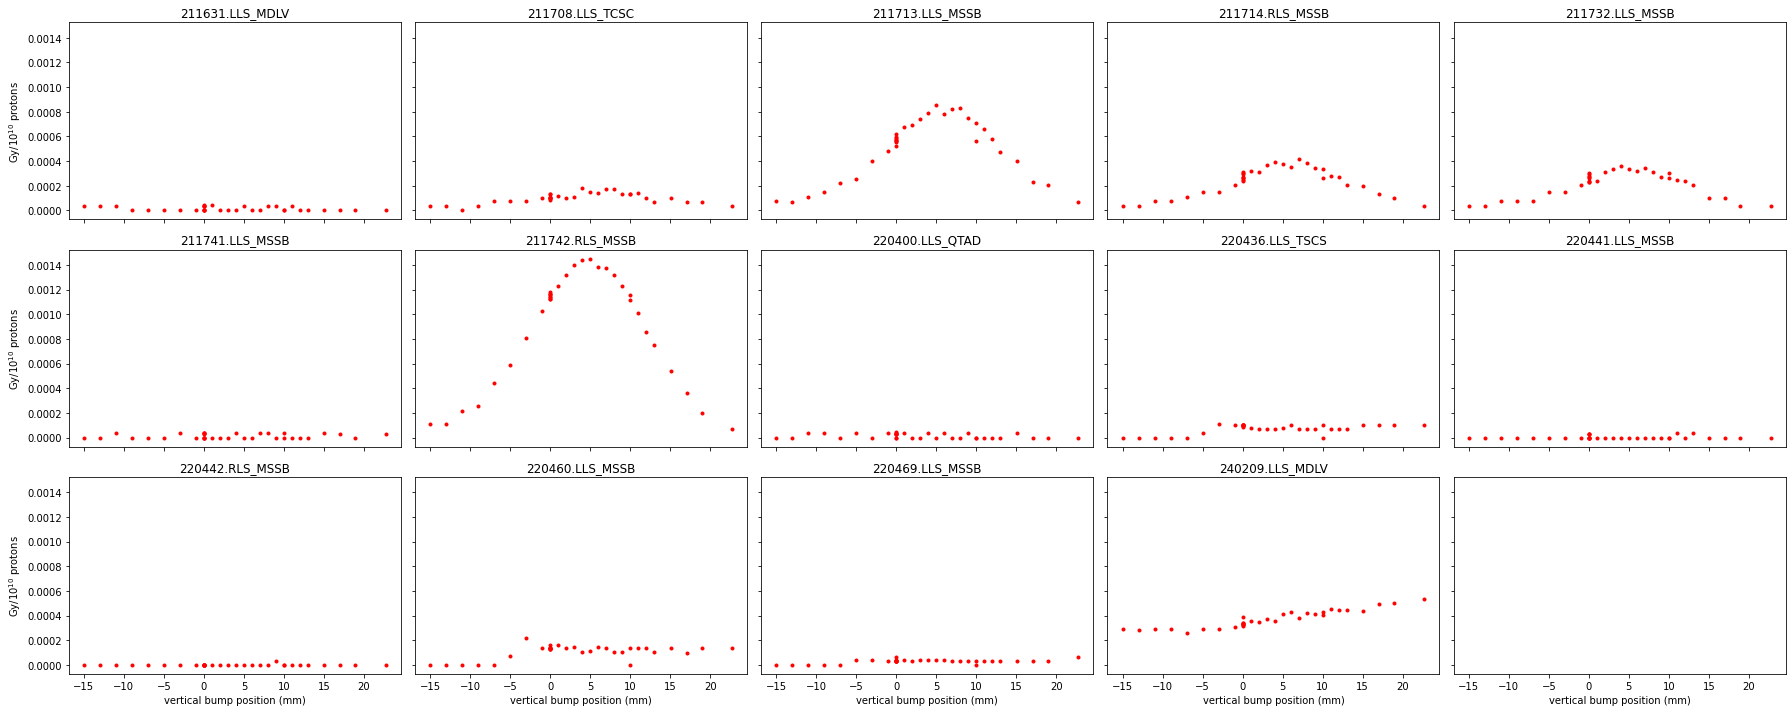

In [255]:
blms = [col for col in df_scan.columns if 'BLM' in col]
blms.sort()

fig, axs = plt.subplots(3, 5, figsize=(25, 10), sharex=True, sharey=True, tight_layout=True)

for ax, blm in zip(axs.flatten(), blms):
    ax.set_title(blm.replace('BLM ', ''))
    
    ax.plot(df_scan['knob mean'], df_scan[blm]/df_scan['intensity E10'], 'r.')

for ax in axs[:, 0]:
    ax.set_ylabel('Gy/10$^{10}$ protons')
for ax in axs[-1, :]:
    ax.set_xlabel('vertical bump position (mm)')

![MSSB1](images/BLMS%20MSSB1.png)

### Py scan

In [256]:
k_names = ['MDLV.2115/K', 'MDLV.2116/K', 'MDLV.2201/K', 'MDLV.2204/K', 'MBB.2113/K', 'MPLS.2115/K', 'MDAH.2201/K', 'MDAH.2303/K']
default_strength = all_data[k_names].between_time('12:35', '12:38').mean().to_dict()
all_data[k_names].between_time('12:35', '12:38').std()

MDLV.2115/K    1.212369e-09
MDLV.2116/K    6.048866e-09
MDLV.2201/K    1.253469e-09
MDLV.2204/K    2.612105e-09
MBB.2113/K     2.550111e-09
MPLS.2115/K    1.661623e-09
MDAH.2201/K    2.978913e-09
MDAH.2303/K    7.822271e-09
dtype: float64

In [257]:
knob = {
    'MDLV.2115/K': -20.18e-6/100,
    'MDLV.2116/K': 100.16e-6/100,
    'MDLV.2201/K': -95.66e-6/100,
    'MDLV.2204/K': 37.79e-6/100,
    }



def knob_values(row, knob):
    knob_values = []
    for key in knob:
        val = (row[key]-default_strength[key])/knob[key]
        knob_values.append(val)
    knob_values = np.array(knob_values)
    return knob_values, knob_values.mean(), knob_values.std()

all_data[['knob', 'knob mean', 'knob std']] = all_data[k_names].apply(lambda row: knob_values(row, knob), axis=1, result_type='expand')
all_data['knob mean+'] = all_data['knob mean']+all_data['knob std']

df_scan =  all_data[all_data['intensity E10'].between(10, 100)].between_time('12:40', '13:10')
all_scans['18 smallerV py'] = df_scan

(-70.03474037898366, 90.27402849610142)

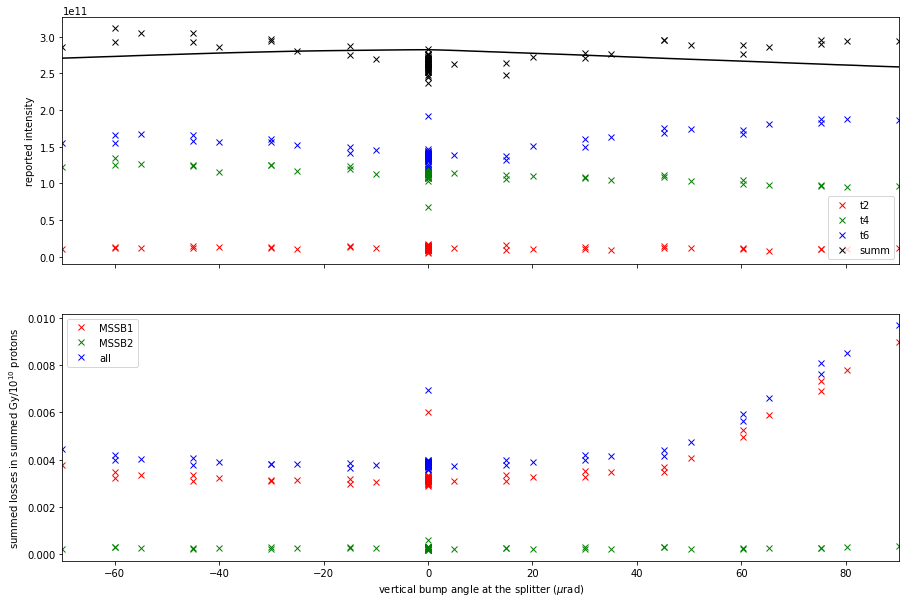

In [258]:
fig, axs = plt.subplots(2, 1, figsize=(15, 10), sharex=True)

axs[1].set_xlabel('vertical bump angle at the splitter ($\mu$rad)')

t2 = 'BSI.230705'
t4 = 'BSI.240610'
t6 = 'BSI.251010'

ax = axs[0]
ax.plot(df_scan['knob mean'], df_scan[t2], 'rx', label='t2')
ax.plot(df_scan['knob mean'], df_scan[t4], 'gx', label='t4')
ax.plot(df_scan['knob mean'], df_scan[t6], 'bx', label='t6')
ax.plot(df_scan['knob mean'], df_scan[t2]+df_scan[t4]+df_scan[t6], 'kx', label='summ')
ax.legend()
ax.set_ylabel('reported intensity')

df_model = pd.read_pickle('efficiency_angles_py.pckl')
# ax = ax.twinx()
Vscale, Xoffset = 3e11, 0
# ax.plot(df_model['positions']*1e3+Xoffset, df_model['smallerV top']*Vscale, 'g-')
# ax.plot(df_model['positions']*1e3+Xoffset, df_model['smallerV bottom']*Vscale, 'b-')
ax.plot(df_model['angles']*1e6+Xoffset, (1-df_model['smallerV lost'])*Vscale, 'k-')


# ax.plot(df_model['positions']*1e3+Xoffset, df_model['nominal top']*Vscale, 'g-', alpha=0.1)
# ax.plot(df_model['positions']*1e3+Xoffset, df_model['nominal bottom']*Vscale, 'b-', alpha=0.1)
# ax.plot(df_model['positions']*1e3+Xoffset, (1-df_model['nominal lost'])*Vscale, 'k-', alpha=0.1)


# ax.set_xlim(df_scan['knob mean'].min(), df_scan['knob mean'].max())


ax = axs[1]
ax.set_ylabel('summed losses in summed Gy/10$^{10}$ protons')
ax.plot(df_scan['knob mean'], df_scan['blms MSSB1']/df_scan['intensity E10'], 'rx', label='MSSB1')
ax.plot(df_scan['knob mean'], df_scan['blms MSSB2']/df_scan['intensity E10'], 'gx', label='MSSB2')
ax.plot(df_scan['knob mean'], df_scan['blms']/df_scan['intensity E10'], 'bx', label='all')
ax.legend()

# df_model = pd.read_pickle('efficiency_positions_y.pckl')
# # ax = ax.twinx()
# Vscale, Xoffset = 0.06, 5.6
# ax.plot(df_model['positions']*1e3+Xoffset, (df_model['smallerV lost'])*Vscale, 'k-')


# ax.plot(df_model['positions']*1e3+Xoffset, (df_model['nominal lost'])*Vscale, 'k-', alpha=0.1)


ax.set_xlim(df_scan['knob mean'].min(), df_scan['knob mean'].max())


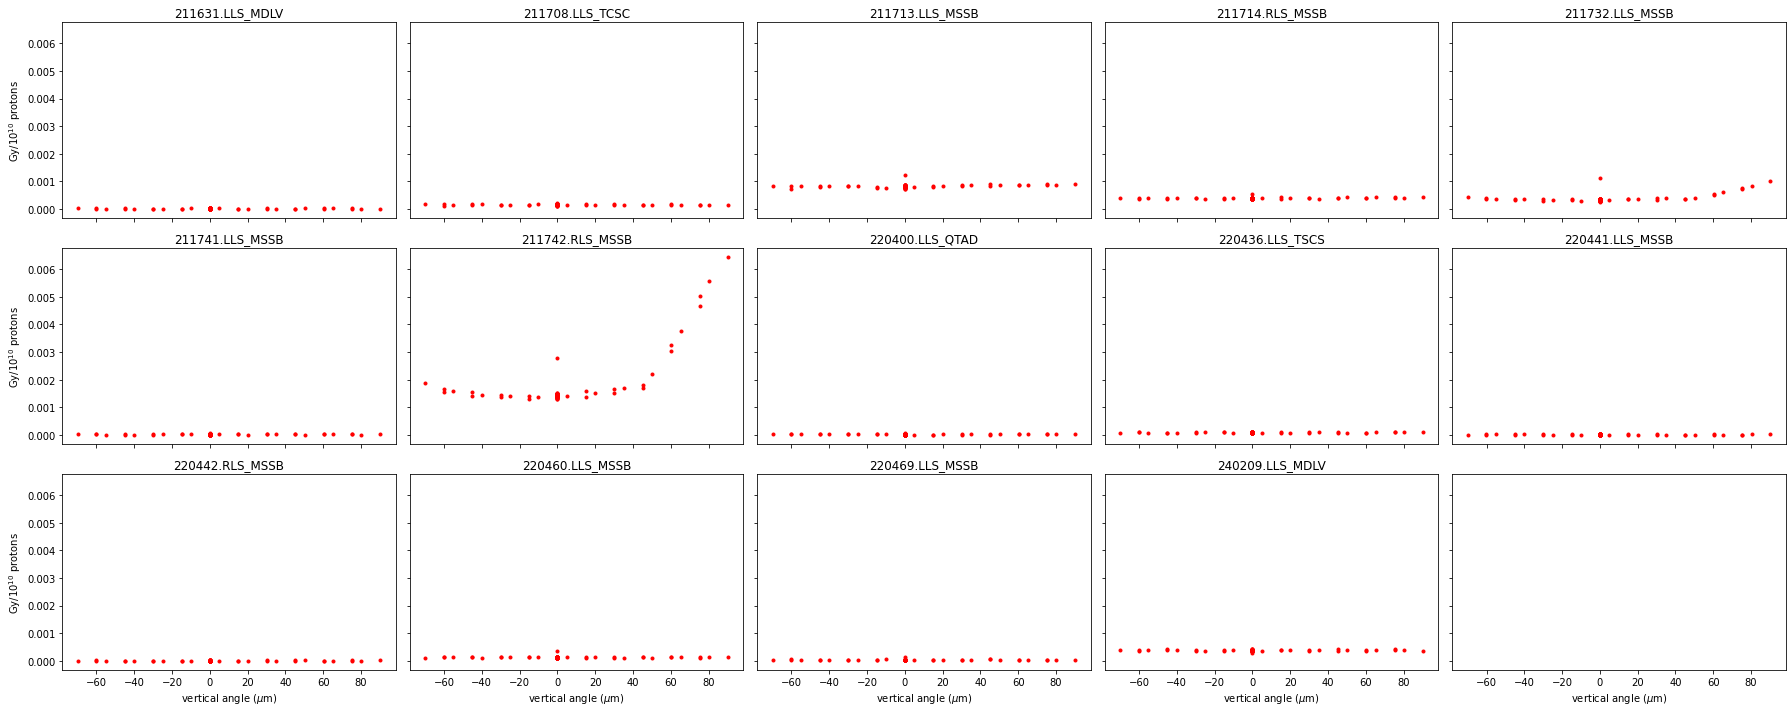

In [259]:
blms = [col for col in df_scan.columns if 'BLM' in col]
blms.sort()

fig, axs = plt.subplots(3, 5, figsize=(25, 10), sharex=True, sharey=True, tight_layout=True)

for ax, blm in zip(axs.flatten(), blms):
    ax.set_title(blm.replace('BLM ', ''))
    
    ax.plot(df_scan['knob mean'], df_scan[blm]/df_scan['intensity E10'], 'r.')

for ax in axs[:, 0]:
    ax.set_ylabel('Gy/10$^{10}$ protons')
for ax in axs[-1, :]:
    ax.set_xlabel('vertical angle ($\mu$m)')

### x position

In [278]:
k_names = ['MDLV.2115/K', 'MDLV.2116/K', 'MDLV.2201/K', 'MDLV.2204/K', 'MBB.2113/K', 'MPLS.2115/K', 'MDAH.2201/K', 'MDAH.2303/K']
default_strength = all_data[k_names].between_time('13:02', '13:05').mean().to_dict()
all_data[k_names].between_time('12:35', '12:38').std()

knob = {#posiiton bump in in H
#     'MBB.2113/K': 4.04e-6,
    'MPLS.2115/K': 27.91e-6,
    'MDAH.2201/K': 30.83e-6,
    'MDAH.2303/K': 8.27e-6,
}



def knob_values(row, knob):
    knob_values = []
    for key in knob:
        val = (row[key]-default_strength[key])/knob[key]
        knob_values.append(val)
    knob_values = np.array(knob_values)
    return knob_values, knob_values.mean(), knob_values.std()

all_data[['knob', 'knob mean', 'knob std']] = all_data[k_names].apply(lambda row: knob_values(row, knob), axis=1, result_type='expand')
all_data['knob mean+'] = all_data['knob mean']+all_data['knob std']

df_scan =  all_data[all_data['intensity E10'].between(20, 60)].between_time('13:10', '13:23')
all_scans['18 smallerV x'] = df_scan

(-14.99633823348455, 11.994993899414812)

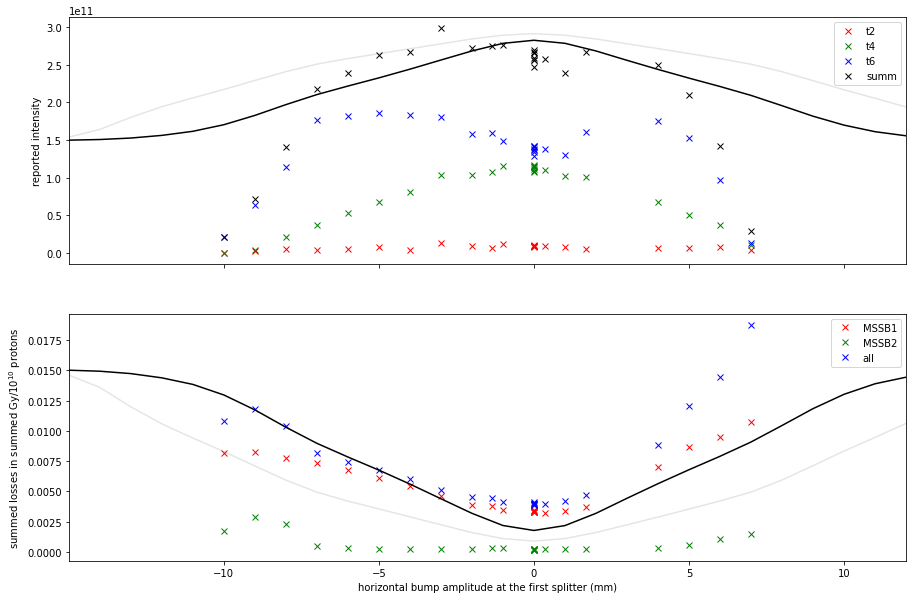

In [279]:
fig, axs = plt.subplots(2, 1, figsize=(15, 10), sharex=True)

axs[1].set_xlabel('horizontal bump amplitude at the first splitter (mm)')

t2 = 'BSI.230705'
t4 = 'BSI.240610'
t6 = 'BSI.251010'

ax = axs[0]
ax.plot(df_scan['knob mean'], df_scan[t2], 'rx', label='t2')
ax.plot(df_scan['knob mean'], df_scan[t4], 'gx', label='t4')
ax.plot(df_scan['knob mean'], df_scan[t6], 'bx', label='t6')
ax.plot(df_scan['knob mean'], df_scan[t2]+df_scan[t4]+df_scan[t6], 'kx', label='summ')
ax.legend()
ax.set_ylabel('reported intensity')

df_model = pd.read_pickle('efficiency_positions_x.pckl')
# ax = ax.twinx()
Vscale, Xoffset = 3e11, 0
# ax.plot(df_model['positions']*1e3+Xoffset, df_model['smallerV top']*Vscale, 'g-')
# ax.plot(df_model['positions']*1e3+Xoffset, df_model['smallerV bottom']*Vscale, 'b-')
ax.plot(df_model['positions']*1e3+Xoffset, (1-df_model['smallerV lost'])*Vscale, 'k-')


# ax.plot(df_model['positions']*1e3+Xoffset, df_model['nominal top']*Vscale, 'g-', alpha=0.1)
# ax.plot(df_model['positions']*1e3+Xoffset, df_model['nominal bottom']*Vscale, 'b-', alpha=0.1)
ax.plot(df_model['positions']*1e3+Xoffset, (1-df_model['nominal lost'])*Vscale, 'k-', alpha=0.1)


ax.set_xlim(df_scan['knob mean'].min(), df_scan['knob mean'].max())


ax = axs[1]
ax.set_ylabel('summed losses in summed Gy/10$^{10}$ protons')
ax.plot(df_scan['knob mean'], df_scan['blms MSSB1']/df_scan['intensity E10'], 'rx', label='MSSB1')
ax.plot(df_scan['knob mean'], df_scan['blms MSSB2']/df_scan['intensity E10'], 'gx', label='MSSB2')
ax.plot(df_scan['knob mean'], df_scan['blms']/df_scan['intensity E10'], 'bx', label='all')
ax.legend()

# ax = ax.twinx()
Vscale= 0.03
ax.plot(df_model['positions']*1e3+Xoffset, (df_model['smallerV lost'])*Vscale, 'k-')


ax.plot(df_model['positions']*1e3+Xoffset, (df_model['nominal lost'])*Vscale, 'k-', alpha=0.1)


ax.set_xlim(df_scan['knob mean'].min()-5, df_scan['knob mean'].max()+5)

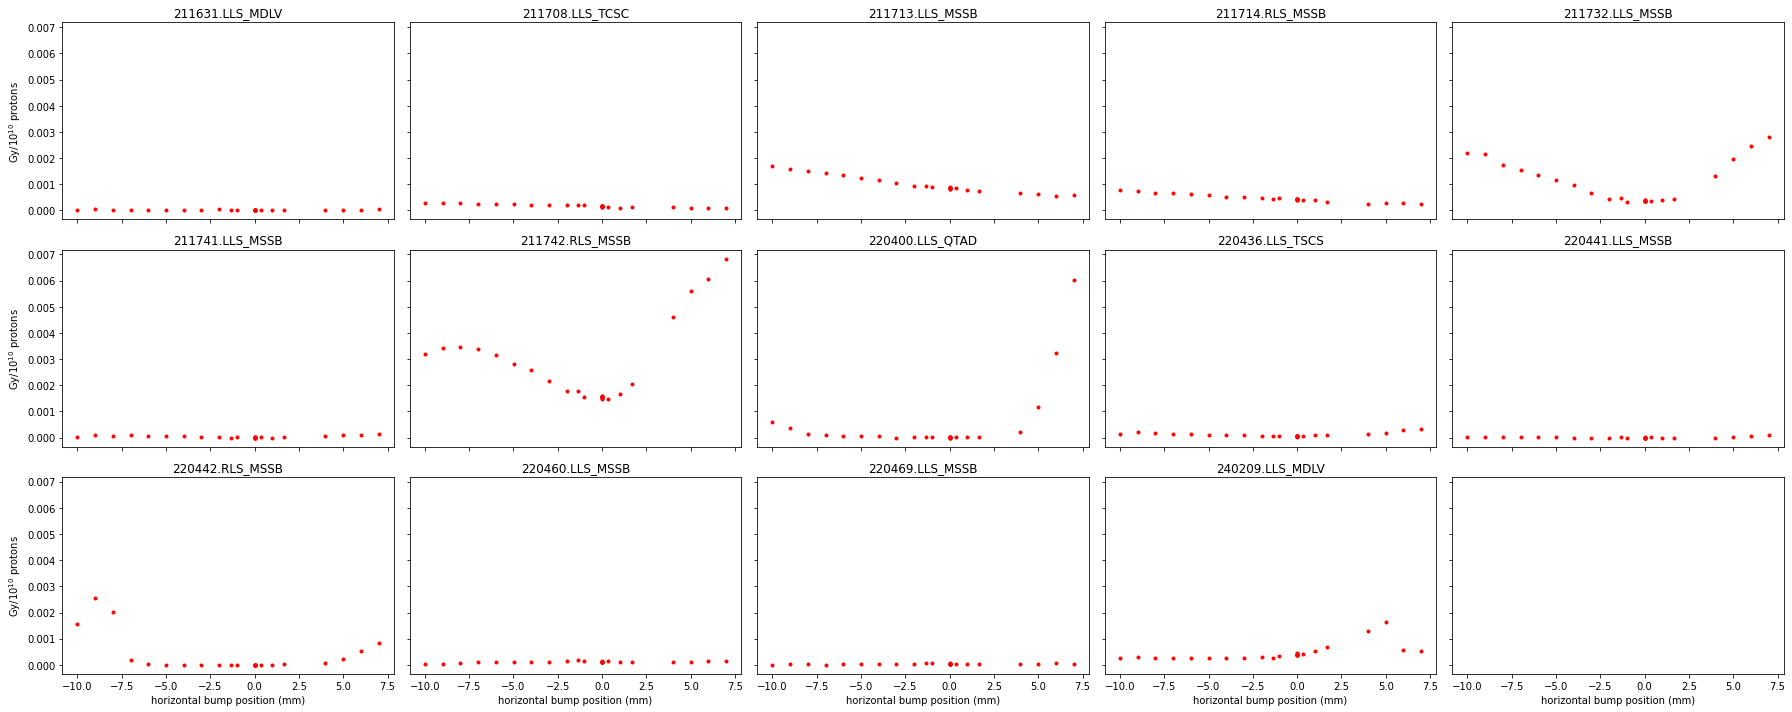

In [280]:
blms = [col for col in df_scan.columns if 'BLM' in col]
blms.sort()

fig, axs = plt.subplots(3, 5, figsize=(25, 10), sharex=True, sharey=True, tight_layout=True)

for ax, blm in zip(axs.flatten(), blms):
    ax.set_title(blm.replace('BLM ', ''))
    
    ax.plot(df_scan['knob mean'], df_scan[blm]/df_scan['intensity E10'], 'r.')

for ax in axs[:, 0]:
    ax.set_ylabel('Gy/10$^{10}$ protons')
for ax in axs[-1, :]:
    ax.set_xlabel('horizontal bump position (mm)')

![MSSB1](images/BLMS%20MSSB1.png)

### px scan

In [263]:
k_names = ['MDLV.2115/K', 'MDLV.2116/K', 'MDLV.2201/K', 'MDLV.2204/K', 'MBB.2113/K', 'MPLS.2115/K', 'MDAH.2201/K', 'MDAH.2303/K']
default_strength = all_data[k_names].between_time('13:02', '13:05').mean().to_dict()
all_data[k_names].between_time('12:35', '12:38').std()

knob = {#angle bump in H, 1urad
#     'MBB.2113/K': -16.15e-6/100,
    'MPLS.2115/K': 6.99e-6/100,
    'MDAH.2201/K': 36.10e-6/100,
    'MDAH.2303/K': 31.18e-6/100,
}


def knob_values(row, knob):
    knob_values = []
    for key in knob:
        val = (row[key]-default_strength[key])/knob[key]
        knob_values.append(val)
    knob_values = np.array(knob_values)
    return knob_values, knob_values.mean(), knob_values.std()

all_data[['knob', 'knob mean', 'knob std']] = all_data[k_names].apply(lambda row: knob_values(row, knob), axis=1, result_type='expand')
all_data['knob mean+'] = all_data['knob mean']+all_data['knob std']

df_scan =  all_data[all_data['intensity E10'].between(20, 60)].between_time('13:31', '13:42')
all_scans['18 smallerV px'] = df_scan

(-109.82926333463433, 99.98789738057869)

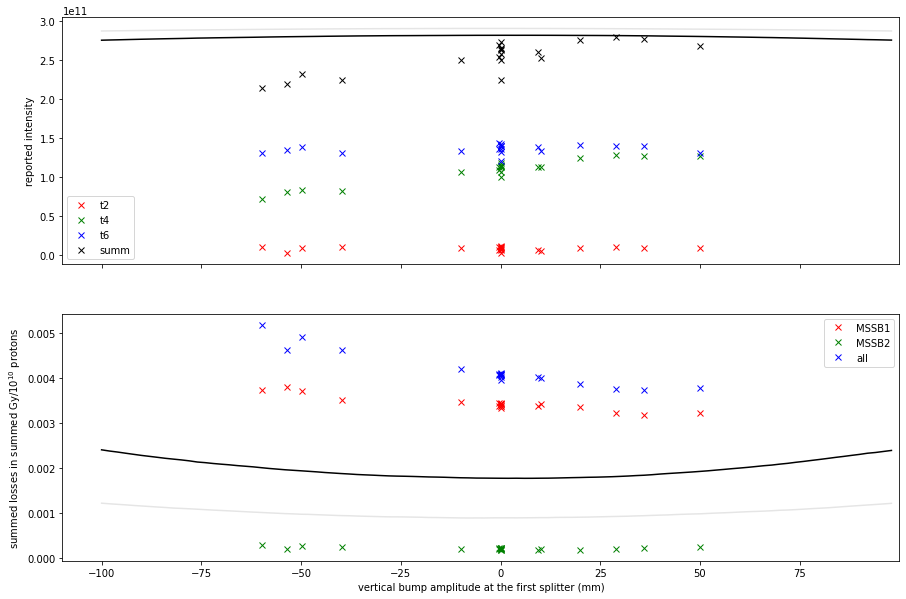

In [264]:
fig, axs = plt.subplots(2, 1, figsize=(15, 10), sharex=True)

axs[1].set_xlabel('vertical bump amplitude at the first splitter (mm)')

t2 = 'BSI.230705'
t4 = 'BSI.240610'
t6 = 'BSI.251010'

ax = axs[0]
ax.plot(df_scan['knob mean'], df_scan[t2], 'rx', label='t2')
ax.plot(df_scan['knob mean'], df_scan[t4], 'gx', label='t4')
ax.plot(df_scan['knob mean'], df_scan[t6], 'bx', label='t6')
ax.plot(df_scan['knob mean'], df_scan[t2]+df_scan[t4]+df_scan[t6], 'kx', label='summ')
ax.legend()
ax.set_ylabel('reported intensity')

df_model = pd.read_pickle('efficiency_angles_px.pckl')
# ax = ax.twinx()
Vscale, Xoffset = 3e11, 0
# ax.plot(df_model['positions']*1e3+Xoffset, df_model['smallerV top']*Vscale, 'g-')
# ax.plot(df_model['positions']*1e3+Xoffset, df_model['smallerV bottom']*Vscale, 'b-')
ax.plot(df_model['angles']*1e6+Xoffset, (1-df_model['smallerV lost'])*Vscale, 'k-')


# ax.plot(df_model['positions']*1e3+Xoffset, df_model['nominal top']*Vscale, 'g-', alpha=0.1)
# ax.plot(df_model['positions']*1e3+Xoffset, df_model['nominal bottom']*Vscale, 'b-', alpha=0.1)
ax.plot(df_model['angles']*1e6+Xoffset, (1-df_model['nominal lost'])*Vscale, 'k-', alpha=0.1)


ax.set_xlim(df_scan['knob mean'].min(), df_scan['knob mean'].max())


ax = axs[1]
ax.set_ylabel('summed losses in summed Gy/10$^{10}$ protons')
ax.plot(df_scan['knob mean'], df_scan['blms MSSB1']/df_scan['intensity E10'], 'rx', label='MSSB1')
ax.plot(df_scan['knob mean'], df_scan['blms MSSB2']/df_scan['intensity E10'], 'gx', label='MSSB2')
ax.plot(df_scan['knob mean'], df_scan['blms']/df_scan['intensity E10'], 'bx', label='all')
ax.legend()

# ax = ax.twinx()
Vscale= 0.03
ax.plot(df_model['angles']*1e6+Xoffset, (df_model['smallerV lost'])*Vscale, 'k-')


ax.plot(df_model['angles']*1e6+Xoffset, (df_model['nominal lost'])*Vscale, 'k-', alpha=0.1)


ax.set_xlim(df_scan['knob mean'].min()-50, df_scan['knob mean'].max()+50)

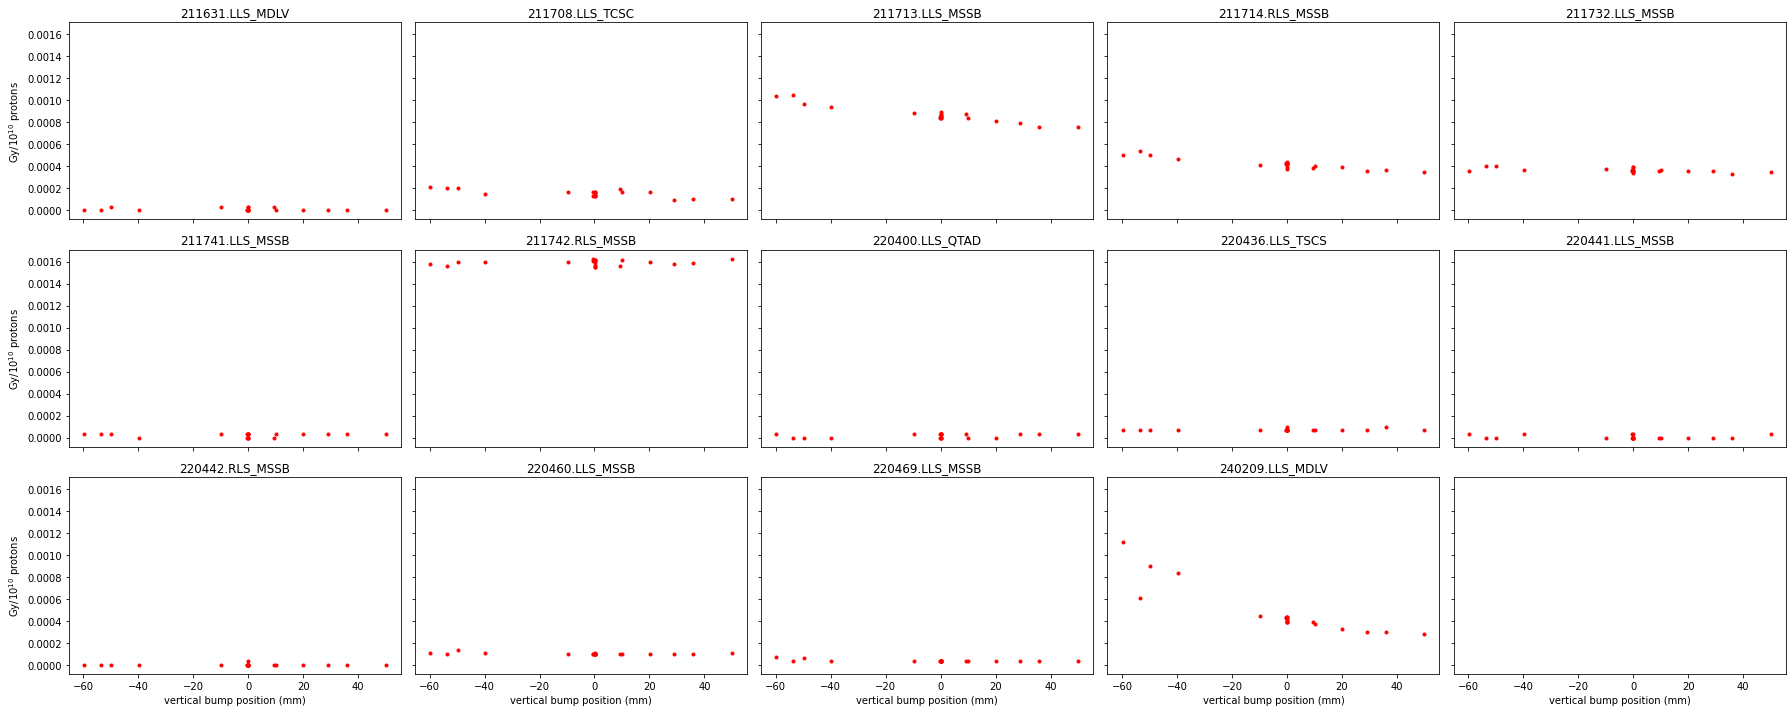

In [265]:
blms = [col for col in df_scan.columns if 'BLM' in col]
blms.sort()

fig, axs = plt.subplots(3, 5, figsize=(25, 10), sharex=True, sharey=True, tight_layout=True)

for ax, blm in zip(axs.flatten(), blms):
    ax.set_title(blm.replace('BLM ', ''))
    
    ax.plot(df_scan['knob mean'], df_scan[blm]/df_scan['intensity E10'], 'r.')

for ax in axs[:, 0]:
    ax.set_ylabel('Gy/10$^{10}$ protons')
for ax in axs[-1, :]:
    ax.set_xlabel('vertical bump position (mm)')

## Nominal optics

## yscan

In [287]:
k_names = ['MDLV.2115/K', 'MDLV.2116/K', 'MDLV.2201/K', 'MDLV.2204/K', 'MBB.2113/K', 'MPLS.2115/K', 'MDAH.2201/K', 'MDAH.2303/K']
default_strength = all_data[k_names].between_time('13:45', '13:50').mean().to_dict()
all_data[k_names].between_time('13:45', '13:48').std()

knob = { #position bump, +1mm in vertical normal beam
    'MDLV.2115/K': 10.22e-6,
    'MDLV.2116/K': 4.08e-6,
    'MDLV.2201/K': -12.27e-6,
    'MDLV.2204/K': 11.43e-6,
    }

def knob_values(row, knob):
    knob_values = []
    for key in knob:
        val = (row[key]-default_strength[key])/knob[key]
        knob_values.append(val)
    knob_values = np.array(knob_values)
    return knob_values, knob_values.mean(), knob_values.std()

all_data[['knob', 'knob mean', 'knob std']] = all_data[k_names].apply(lambda row: knob_values(row, knob), axis=1, result_type='expand')
all_data['knob mean+'] = all_data['knob mean']+all_data['knob std']

df_scan =  all_data[all_data['intensity E10'].between(10, 100)].between_time('13:50', '14:39')
all_scans['18 normalV y'] = df_scan

(-37.99516212815032, 38.05380528637253)

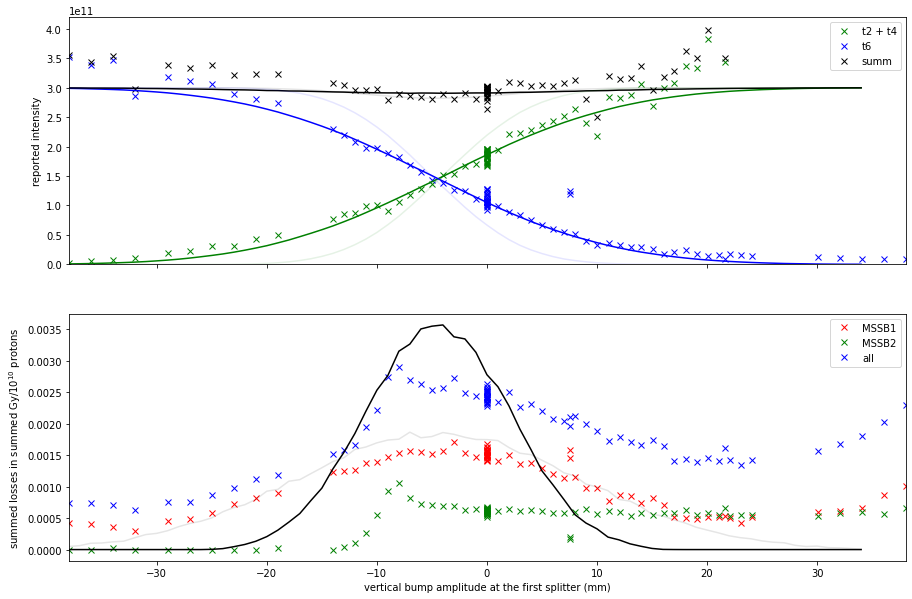

In [288]:
fig, axs = plt.subplots(2, 1, figsize=(15, 10), sharex=True)

axs[1].set_xlabel('vertical bump amplitude at the first splitter (mm)')

t2 = 'BSI.230705'
t4 = 'BSI.240610'
t6 = 'BSI.251010'

ax = axs[0]
# ax.plot(df_scan['knob mean'], df_scan[t2], 'rx', label='t2')
ax.plot(df_scan['knob mean'], df_scan[t2]+df_scan[t4], 'gx', label='t2 + t4')
ax.plot(df_scan['knob mean'], df_scan[t6], 'bx', label='t6')
ax.plot(df_scan['knob mean'], df_scan[t2]+df_scan[t4]+df_scan[t6], 'kx', label='summ')
ax.legend()
ax.set_ylabel('reported intensity')

df_model = pd.read_pickle('efficiency_positions_y.pckl')
# ax = ax.twinx()
Vscale, Xoffset = 3e11, -5
ax.plot(df_model['positions']*1e3+Xoffset, df_model['nominal top']*Vscale, 'g-')
ax.plot(df_model['positions']*1e3+Xoffset, df_model['nominal bottom']*Vscale, 'b-')
ax.plot(df_model['positions']*1e3+Xoffset, (1-df_model['nominal lost'])*Vscale, 'k-')

ax.plot(df_model['positions']*1e3+Xoffset, df_model['smallerV top']*Vscale, 'g-', alpha=0.1)
ax.plot(df_model['positions']*1e3+Xoffset, df_model['smallerV bottom']*Vscale, 'b-', alpha=0.1)
ax.plot(df_model['positions']*1e3+Xoffset, (1-df_model['smallerV lost'])*Vscale, 'k-', alpha=0.1)
ax.set_ylim(0, 4.2e11)

ax.set_xlim(df_scan['knob mean'].min(), df_scan['knob mean'].max())


ax = axs[1]
ax.set_ylabel('summed losses in summed Gy/10$^{10}$ protons')
ax.plot(df_scan['knob mean'], df_scan['blms MSSB1']/df_scan['intensity E10'], 'rx', label='MSSB1')
ax.plot(df_scan['knob mean'], df_scan['blms MSSB2']/df_scan['intensity E10'], 'gx', label='MSSB2')
ax.plot(df_scan['knob mean'], df_scan['blms']/df_scan['intensity E10'], 'bx', label='all')
ax.legend()

df_model = pd.read_pickle('efficiency_positions_y.pckl')
# ax = ax.twinx()
Vscale= 0.06
ax.plot(df_model['positions']*1e3+Xoffset, (df_model['smallerV lost'])*Vscale, 'k-')


ax.plot(df_model['positions']*1e3+Xoffset, (df_model['nominal lost'])*Vscale, 'k-', alpha=0.1)


ax.set_xlim(df_scan['knob mean'].min(), df_scan['knob mean'].max())


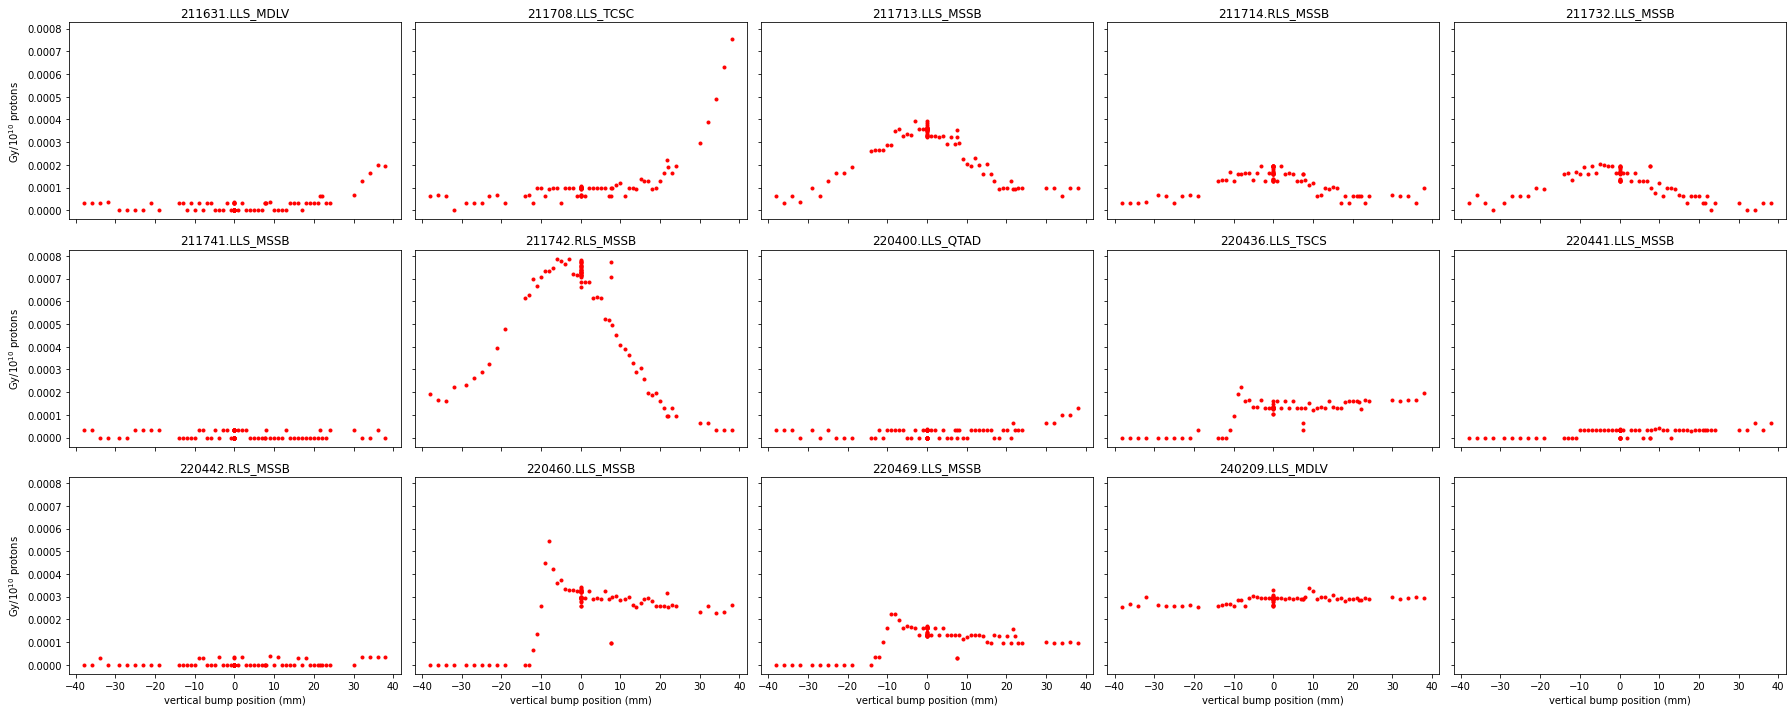

In [289]:
blms = [col for col in df_scan.columns if 'BLM' in col]
blms.sort()

fig, axs = plt.subplots(3, 5, figsize=(25, 10), sharex=True, sharey=True, tight_layout=True)

for ax, blm in zip(axs.flatten(), blms):
    ax.set_title(blm.replace('BLM ', ''))
    
    ax.plot(df_scan['knob mean'], df_scan[blm]/df_scan['intensity E10'], 'r.')

for ax in axs[:, 0]:
    ax.set_ylabel('Gy/10$^{10}$ protons')
for ax in axs[-1, :]:
    ax.set_xlabel('vertical bump position (mm)')

(-37.99516212815032, 38.05380528637253)

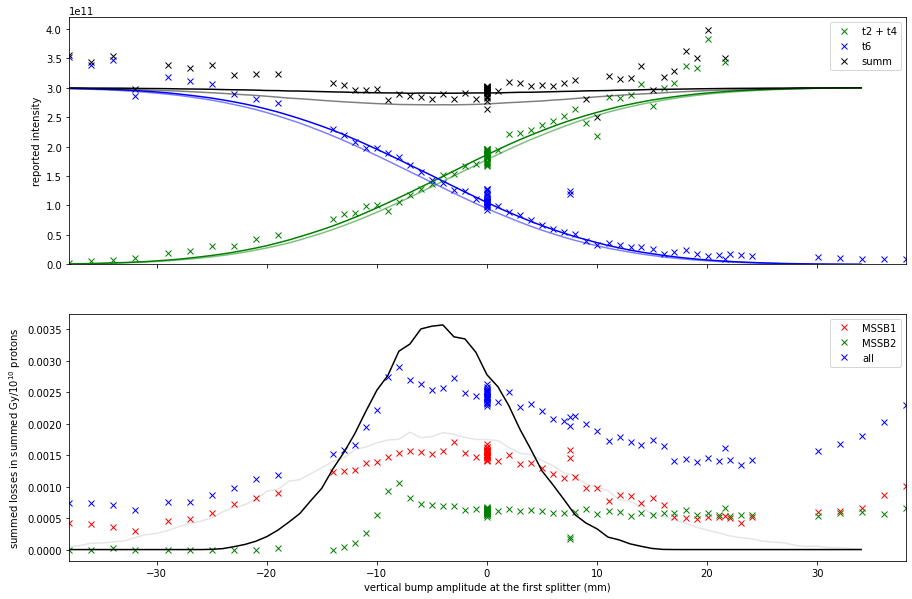

In [290]:
fig, axs = plt.subplots(2, 1, figsize=(15, 10), sharex=True)

axs[1].set_xlabel('vertical bump amplitude at the first splitter (mm)')

t2 = 'BSI.230705'
t4 = 'BSI.240610'
t6 = 'BSI.251010'

ax = axs[0]
# ax.plot(df_scan['knob mean'], df_scan[t2], 'rx', label='t2')
ax.plot(df_scan['knob mean'], df_scan[t2]+df_scan[t4], 'gx', label='t2 + t4')
ax.plot(df_scan['knob mean'], df_scan[t6], 'bx', label='t6')
ax.plot(df_scan['knob mean'], df_scan[t2]+df_scan[t4]+df_scan[t6], 'kx', label='summ')
ax.legend()
ax.set_ylabel('reported intensity')

df_model = pd.read_pickle('efficiency_positions_y.pckl')
df_model_bad = pd.read_pickle('efficiency_bad-aligned_positions_y.pckl')
# ax = ax.twinx()
Vscale, Xoffset = 3e11, -5
ax.plot(df_model['positions']*1e3+Xoffset, df_model['nominal top']*Vscale, 'g-')
ax.plot(df_model['positions']*1e3+Xoffset, df_model['nominal bottom']*Vscale, 'b-')
ax.plot(df_model['positions']*1e3+Xoffset, (1-df_model['nominal lost'])*Vscale, 'k-')

ax.plot(df_model_bad['positions']*1e3+Xoffset, df_model_bad['nominal top']*Vscale, 'g-', alpha=0.5)
ax.plot(df_model_bad['positions']*1e3+Xoffset, df_model_bad['nominal bottom']*Vscale, 'b-', alpha=0.5)
ax.plot(df_model_bad['positions']*1e3+Xoffset, (1-df_model_bad['nominal lost'])*Vscale, 'k-', alpha=0.5)
ax.set_ylim(0, 4.2e11)

ax.set_xlim(df_scan['knob mean'].min(), df_scan['knob mean'].max())


ax = axs[1]
ax.set_ylabel('summed losses in summed Gy/10$^{10}$ protons')
ax.plot(df_scan['knob mean'], df_scan['blms MSSB1']/df_scan['intensity E10'], 'rx', label='MSSB1')
ax.plot(df_scan['knob mean'], df_scan['blms MSSB2']/df_scan['intensity E10'], 'gx', label='MSSB2')
ax.plot(df_scan['knob mean'], df_scan['blms']/df_scan['intensity E10'], 'bx', label='all')
ax.legend()

df_model = pd.read_pickle('efficiency_positions_y.pckl')
# ax = ax.twinx()
Vscale= 0.06
ax.plot(df_model['positions']*1e3+Xoffset, (df_model['smallerV lost'])*Vscale, 'k-')


ax.plot(df_model['positions']*1e3+Xoffset, (df_model['nominal lost'])*Vscale, 'k-', alpha=0.1)


ax.set_xlim(df_scan['knob mean'].min(), df_scan['knob mean'].max())

### py scan

In [269]:
k_names = ['MDLV.2115/K', 'MDLV.2116/K', 'MDLV.2201/K', 'MDLV.2204/K', 'MBB.2113/K', 'MPLS.2115/K', 'MDAH.2201/K', 'MDAH.2303/K']
default_strength = all_data[k_names].between_time('13:45', '13:50').mean().to_dict()
all_data[k_names].between_time('13:45', '13:48').std()


knob = {#angle bump, 1urad at the splitter normal beam
    'MDLV.2115/K': -18.37e-6/100,
    'MDLV.2116/K': 104.38e-6/100,
    'MDLV.2201/K': -95.84e-6/100,
    'MDLV.2204/K': 39.45e-6/100,
    }

def knob_values(row, knob):
    knob_values = []
    for key in knob:
        val = (row[key]-default_strength[key])/knob[key]
        knob_values.append(val)
    knob_values = np.array(knob_values)
    return knob_values, knob_values.mean(), knob_values.std()

all_data[['knob', 'knob mean', 'knob std']] = all_data[k_names].apply(lambda row: knob_values(row, knob), axis=1, result_type='expand')
all_data['knob mean+'] = all_data['knob mean']+all_data['knob std']

df_scan =  all_data[all_data['intensity E10'].between(20, 60)].between_time('14:40', '15:00')
all_scans['18 normalV py'] = df_scan

(-85.03970277949297, 100.21851148909566)

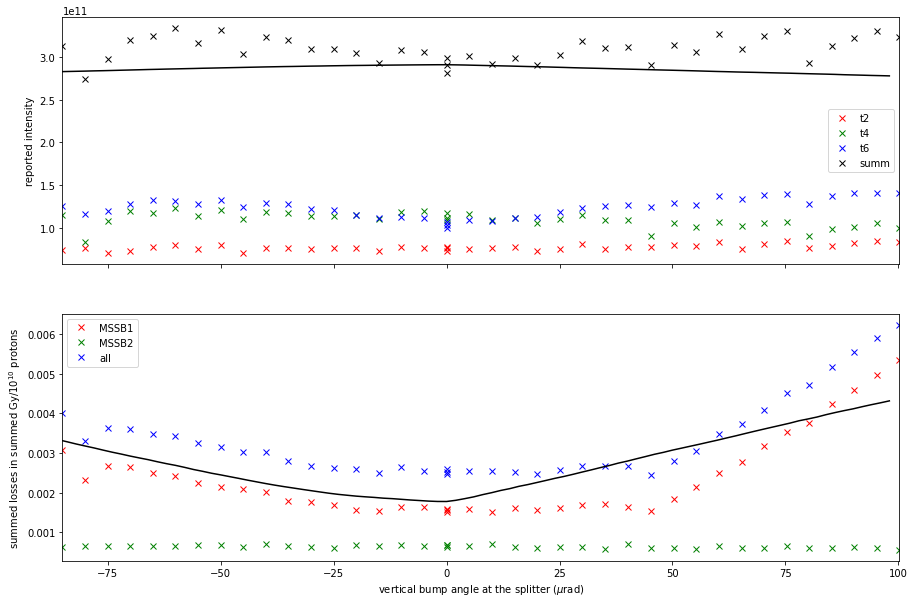

In [270]:
fig, axs = plt.subplots(2, 1, figsize=(15, 10), sharex=True)

axs[1].set_xlabel('vertical bump angle at the splitter ($\mu$rad)')

t2 = 'BSI.230705'
t4 = 'BSI.240610'
t6 = 'BSI.251010'

ax = axs[0]
ax.plot(df_scan['knob mean'], df_scan[t2], 'rx', label='t2')
ax.plot(df_scan['knob mean'], df_scan[t4], 'gx', label='t4')
ax.plot(df_scan['knob mean'], df_scan[t6], 'bx', label='t6')
ax.plot(df_scan['knob mean'], df_scan[t2]+df_scan[t4]+df_scan[t6], 'kx', label='summ')
ax.legend()
ax.set_ylabel('reported intensity')

df_model = pd.read_pickle('efficiency_angles_py.pckl')
# ax = ax.twinx()
Vscale, Xoffset = 3e11, 0
# ax.plot(df_model['positions']*1e3+Xoffset, df_model['nominal top']*Vscale, 'g-')
# ax.plot(df_model['positions']*1e3+Xoffset, df_model['nominal bottom']*Vscale, 'b-')
ax.plot(df_model['angles']*1e6+Xoffset, (1-df_model['nominal lost'])*Vscale, 'k-')

# ax.plot(df_model['positions']*1e3+Xoffset, df_model['smallerV top']*Vscale, 'g-', alpha=0.1)
# ax.plot(df_model['positions']*1e3+Xoffset, df_model['smallerV bottom']*Vscale, 'b-', alpha=0.1)
# ax.plot(df_model['angles']*1e6+Xoffset, (1-df_model['smallerV lost'])*Vscale, 'k-', alpha=0.1)

# ax.set_xlim(df_scan['knob mean'].min(), df_scan['knob mean'].max())


ax = axs[1]
ax.set_ylabel('summed losses in summed Gy/10$^{10}$ protons')
ax.plot(df_scan['knob mean'], df_scan['blms MSSB1']/df_scan['intensity E10'], 'rx', label='MSSB1')
ax.plot(df_scan['knob mean'], df_scan['blms MSSB2']/df_scan['intensity E10'], 'gx', label='MSSB2')
ax.plot(df_scan['knob mean'], df_scan['blms']/df_scan['intensity E10'], 'bx', label='all')
ax.legend()

# df_model = pd.read_pickle('efficiency_positions_y.pckl')
# # ax = ax.twinx()
Vscale= 0.03
ax.plot(df_model['angles']*1e6+Xoffset, (df_model['smallerV lost'])*Vscale, 'k-')


# ax.plot(df_model['positions']*1e3+Xoffset, (df_model['nominal lost'])*Vscale, 'k-', alpha=0.1)


ax.set_xlim(df_scan['knob mean'].min(), df_scan['knob mean'].max())

### x scan

In [281]:
k_names = ['MDLV.2115/K', 'MDLV.2116/K', 'MDLV.2201/K', 'MDLV.2204/K', 'MBB.2113/K', 'MPLS.2115/K', 'MDAH.2201/K', 'MDAH.2303/K']
default_strength = all_data[k_names].between_time('13:45', '13:50').mean().to_dict()
all_data[k_names].between_time('13:45', '13:48').std()


knob = {#posiiton bump in in H
#     'MBB.2113/K': 4.22e-6,
    'MPLS.2115/K': 27.37e-6,
    'MDAH.2201/K': 31.74e-6,
    'MDAH.2303/K': 8.44e-6,
}

def knob_values(row, knob):
    knob_values = []
    for key in knob:
        val = (row[key]-default_strength[key])/knob[key]
        knob_values.append(val)
    knob_values = np.array(knob_values)
    return knob_values, knob_values.mean(), knob_values.std()

all_data[['knob', 'knob mean', 'knob std']] = all_data[k_names].apply(lambda row: knob_values(row, knob), axis=1, result_type='expand')
all_data['knob mean+'] = all_data['knob mean']+all_data['knob std']

df_scan =  all_data[all_data['intensity E10'].between(10, 100)].between_time('15:00', '15:20')

(-15.994746123478356, 11.99565737348275)

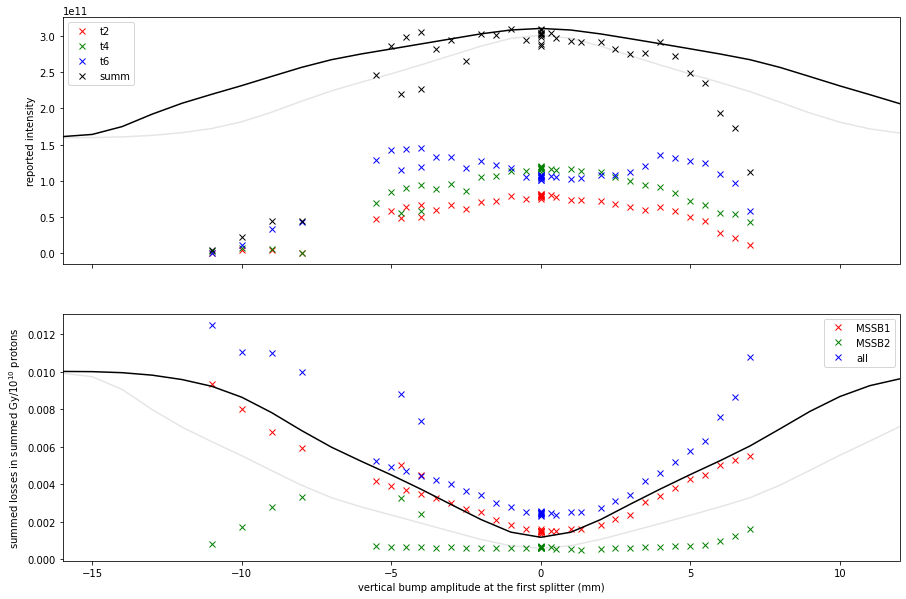

In [282]:
fig, axs = plt.subplots(2, 1, figsize=(15, 10), sharex=True)

axs[1].set_xlabel('horizontal bump amplitude at the first splitter (mm)')

t2 = 'BSI.230705'
t4 = 'BSI.240610'
t6 = 'BSI.251010'

ax = axs[0]
ax.plot(df_scan['knob mean'], df_scan[t2], 'rx', label='t2')
ax.plot(df_scan['knob mean'], df_scan[t4], 'gx', label='t4')
ax.plot(df_scan['knob mean'], df_scan[t6], 'bx', label='t6')
ax.plot(df_scan['knob mean'], df_scan[t2]+df_scan[t4]+df_scan[t6], 'kx', label='summ')
ax.legend()
ax.set_ylabel('reported intensity')

df_model = pd.read_pickle('efficiency_positions_x.pckl')
# ax = ax.twinx()
Vscale, Xoffset = 3.2e11, 0
# ax.plot(df_model['positions']*1e3+Xoffset, df_model['nominal top']*Vscale, 'g-')
# ax.plot(df_model['positions']*1e3+Xoffset, df_model['nominal bottom']*Vscale, 'b-')
ax.plot(df_model['positions']*1e3+Xoffset, (1-df_model['nominal lost'])*Vscale, 'k-')

# ax.plot(df_model['positions']*1e3+Xoffset, df_model['smallerV top']*Vscale, 'g-', alpha=0.1)
# ax.plot(df_model['positions']*1e3+Xoffset, df_model['smallerV bottom']*Vscale, 'b-', alpha=0.1)
ax.plot(df_model['positions']*1e3+Xoffset, (1-df_model['smallerV lost'])*Vscale, 'k-', alpha=0.1)

ax.set_xlim(df_scan['knob mean'].min(), df_scan['knob mean'].max())


ax = axs[1]
ax.set_ylabel('summed losses in summed Gy/10$^{10}$ protons')
ax.plot(df_scan['knob mean'], df_scan['blms MSSB1']/df_scan['intensity E10'], 'rx', label='MSSB1')
ax.plot(df_scan['knob mean'], df_scan['blms MSSB2']/df_scan['intensity E10'], 'gx', label='MSSB2')
ax.plot(df_scan['knob mean'], df_scan['blms']/df_scan['intensity E10'], 'bx', label='all')
ax.legend()

# ax = ax.twinx()
Vscale= 0.020
ax.plot(df_model['positions']*1e3+Xoffset, (df_model['smallerV lost'])*Vscale, 'k-')


ax.plot(df_model['positions']*1e3+Xoffset, (df_model['nominal lost'])*Vscale, 'k-', alpha=0.1)


ax.set_xlim(df_scan['knob mean'].min()-5, df_scan['knob mean'].max()+5)

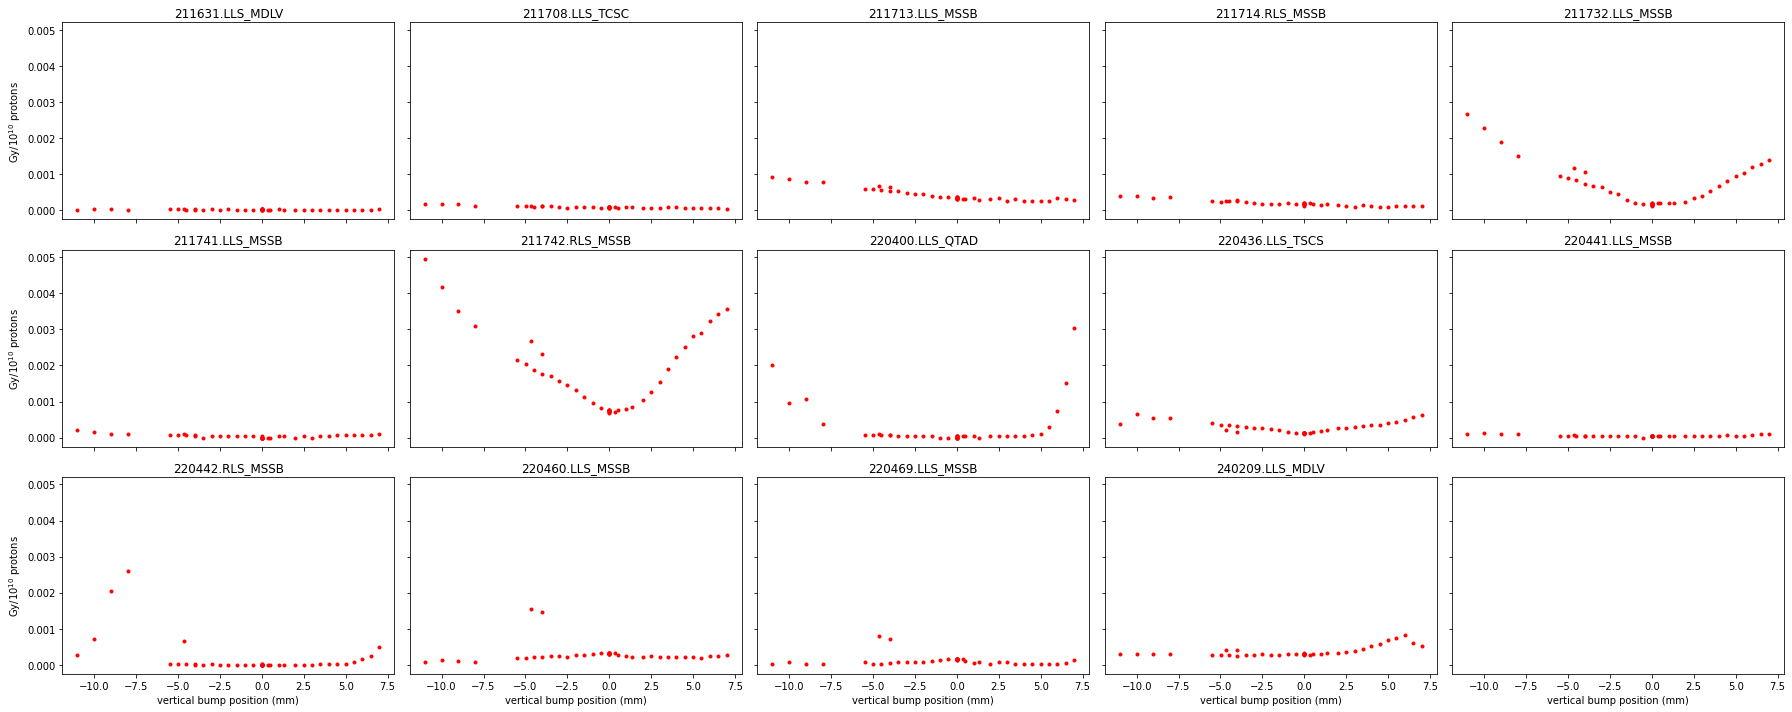

In [273]:
blms = [col for col in df_scan.columns if 'BLM' in col]
blms.sort()

fig, axs = plt.subplots(3, 5, figsize=(25, 10), sharex=True, sharey=True, tight_layout=True)

for ax, blm in zip(axs.flatten(), blms):
    ax.set_title(blm.replace('BLM ', ''))
    
    ax.plot(df_scan['knob mean'], df_scan[blm]/df_scan['intensity E10'], 'r.')

for ax in axs[:, 0]:
    ax.set_ylabel('Gy/10$^{10}$ protons')
for ax in axs[-1, :]:
    ax.set_xlabel('vertical bump position (mm)')

(-15.994746123478356, 11.99565737348275)

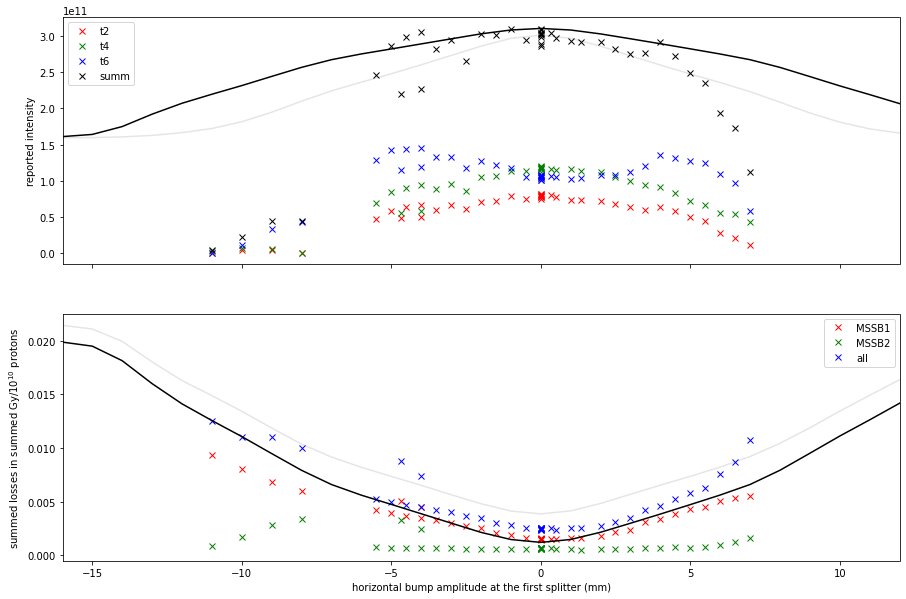

In [285]:
fig, axs = plt.subplots(2, 1, figsize=(15, 10), sharex=True)

axs[1].set_xlabel('horizontal bump amplitude at the first splitter (mm)')

t2 = 'BSI.230705'
t4 = 'BSI.240610'
t6 = 'BSI.251010'

ax = axs[0]
ax.plot(df_scan['knob mean'], df_scan[t2], 'rx', label='t2')
ax.plot(df_scan['knob mean'], df_scan[t4], 'gx', label='t4')
ax.plot(df_scan['knob mean'], df_scan[t6], 'bx', label='t6')
ax.plot(df_scan['knob mean'], df_scan[t2]+df_scan[t4]+df_scan[t6], 'kx', label='summ')
ax.legend()
ax.set_ylabel('reported intensity')

df_model = pd.read_pickle('efficiency_positions_x.pckl')
df_model_bad = pd.read_pickle('efficiency_bad-aligned_positions_x.pckl')

# ax = ax.twinx()
Vscale, Xoffset = 3.2e11, 0
# ax.plot(df_model['positions']*1e3+Xoffset, df_model['nominal top']*Vscale, 'g-')
# ax.plot(df_model['positions']*1e3+Xoffset, df_model['nominal bottom']*Vscale, 'b-')
ax.plot(df_model['positions']*1e3+Xoffset, (1-df_model['nominal lost'])*Vscale, 'k-')

# ax.plot(df_model['positions']*1e3+Xoffset, df_model['smallerV top']*Vscale, 'g-', alpha=0.1)
# ax.plot(df_model['positions']*1e3+Xoffset, df_model['smallerV bottom']*Vscale, 'b-', alpha=0.1)
ax.plot(df_model['positions']*1e3+Xoffset, (1-df_model['smallerV lost'])*Vscale, 'k-', alpha=0.1)

ax.set_xlim(df_scan['knob mean'].min(), df_scan['knob mean'].max())


ax = axs[1]
ax.set_ylabel('summed losses in summed Gy/10$^{10}$ protons')
ax.plot(df_scan['knob mean'], df_scan['blms MSSB1']/df_scan['intensity E10'], 'rx', label='MSSB1')
ax.plot(df_scan['knob mean'], df_scan['blms MSSB2']/df_scan['intensity E10'], 'gx', label='MSSB2')
ax.plot(df_scan['knob mean'], df_scan['blms']/df_scan['intensity E10'], 'bx', label='all')
ax.legend()

# ax = ax.twinx()
Vscale= 0.040
ax.plot(df_model['positions']*1e3+Xoffset, (df_model['nominal lost'])*Vscale, 'k-')


ax.plot(df_model_bad['positions']*1e3+Xoffset, (df_model_bad['nominal lost'])*Vscale, 'k-', alpha=0.1)


ax.set_xlim(df_scan['knob mean'].min()-5, df_scan['knob mean'].max()+5)

### px scan

In [46]:
k_names = ['MDLV.2115/K', 'MDLV.2116/K', 'MDLV.2201/K', 'MDLV.2204/K', 'MBB.2113/K', 'MPLS.2115/K', 'MDAH.2201/K', 'MDAH.2303/K']
default_strength = all_data[k_names].between_time('13:45', '13:50').mean().to_dict()
all_data[k_names].between_time('13:45', '13:48').std()

knob = {#angle bump in H, 1urad
#     'MBB.2113/K': -16.14e-6/100,
    'MPLS.2115/K':16.02e-6/100,
    'MDAH.2201/K': 44.53e-6/100,
    'MDAH.2303/K': 33.44e-6/100,
}

def knob_values(row, knob):
    knob_values = []
    for key in knob:
        val = (row[key]-default_strength[key])/knob[key]
        knob_values.append(val)
    knob_values = np.array(knob_values)
    return knob_values, knob_values.mean(), knob_values.std()

all_data[['knob', 'knob mean', 'knob std']] = all_data[k_names].apply(lambda row: knob_values(row, knob), axis=1, result_type='expand')
all_data['knob mean+'] = all_data['knob mean']+all_data['knob std']

df_scan =  all_data[all_data['intensity E10'].between(20, 60)].between_time('15:20', '15:35')

(-139.86518890536382, 99.93535842987015)

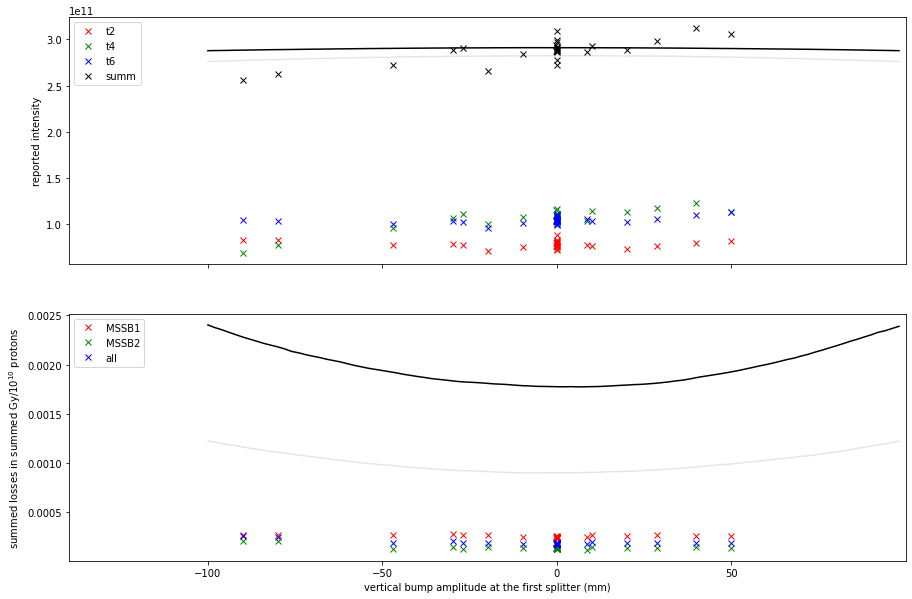

In [47]:
fig, axs = plt.subplots(2, 1, figsize=(15, 10), sharex=True)

axs[1].set_xlabel('vertical bump amplitude at the first splitter (mm)')

t2 = 'BSI.230705'
t4 = 'BSI.240610'
t6 = 'BSI.251010'

ax = axs[0]
ax.plot(df_scan['knob mean'], df_scan[t2], 'rx', label='t2')
ax.plot(df_scan['knob mean'], df_scan[t4], 'gx', label='t4')
ax.plot(df_scan['knob mean'], df_scan[t6], 'bx', label='t6')
ax.plot(df_scan['knob mean'], df_scan[t2]+df_scan[t4]+df_scan[t6], 'kx', label='summ')
ax.legend()
ax.set_ylabel('reported intensity')

df_model = pd.read_pickle('efficiency_angles_px.pckl')
# ax = ax.twinx()
Vscale, Xoffset = 3e11, 0
# ax.plot(df_model['positions']*1e3+Xoffset, df_model['nominal top']*Vscale, 'g-')
# ax.plot(df_model['positions']*1e3+Xoffset, df_model['nominal bottom']*Vscale, 'b-')
ax.plot(df_model['angles']*1e6+Xoffset, (1-df_model['nominal lost'])*Vscale, 'k-')

# ax.plot(df_model['positions']*1e3+Xoffset, df_model['smallerV top']*Vscale, 'g-', alpha=0.1)
# ax.plot(df_model['positions']*1e3+Xoffset, df_model['smallerV bottom']*Vscale, 'b-', alpha=0.1)
ax.plot(df_model['angles']*1e6+Xoffset, (1-df_model['smallerV lost'])*Vscale, 'k-', alpha=0.1)


ax.set_xlim(df_scan['knob mean'].min(), df_scan['knob mean'].max())


ax = axs[1]
ax.set_ylabel('summed losses in summed Gy/10$^{10}$ protons')
ax.plot(df_scan['knob mean'], df_scan['blms MSSB1']/df_scan['intensity E10'], 'rx', label='MSSB1')
ax.plot(df_scan['knob mean'], df_scan['blms MSSB2']/df_scan['intensity E10'], 'gx', label='MSSB2')
ax.plot(df_scan['knob mean'], df_scan['blms']/df_scan['intensity E10'], 'bx', label='all')
ax.legend()

# ax = ax.twinx()
Vscale= 0.03
ax.plot(df_model['angles']*1e6+Xoffset, (df_model['smallerV lost'])*Vscale, 'k-')


ax.plot(df_model['angles']*1e6+Xoffset, (df_model['nominal lost'])*Vscale, 'k-', alpha=0.1)


ax.set_xlim(df_scan['knob mean'].min()-50, df_scan['knob mean'].max()+50)

# MD 25/08

MD elog entry [here](https://logbook.cern.ch/elogbook-server/GET/showEventInLogbook/3358298)

In [291]:
all_data = all_data_all_time.loc['2021-08-25']

### y scan, 2nd splitter

In [292]:
t1, t2 = '7:10', '7:12'
k_names = ['MDLV.2115/K', 'MDLV.2116/K', 'MDLV.2201/K', 'MDLV.2204/K', 'MBB.2113/K', 'MPLS.2115/K', 'MDAH.2201/K', 'MDAH.2303/K', 'MDAV.2301/K', 'MDAV.2305/K']
default_strength = all_data[k_names].between_time(t1, t2).mean().to_dict()
all_data[k_names].between_time(t1, t2).std()


knob = {#position V, 1mm
     'MDLV.2201/K': 12.23e-6,
     'MDLV.2204/K': -11.43e-6,
#      'MDAV.2301/K': -5.86e-6,
#      'MDAV.2305/K': 5.25e-6,
}

def knob_values(row, knob):
    knob_values = []
    for key in knob:
        val = (row[key]-default_strength[key])/knob[key]
        knob_values.append(val)
    knob_values = np.array(knob_values)
    return knob_values, knob_values.mean(), knob_values.std()

all_data[['knob', 'knob mean', 'knob std']] = all_data[k_names].apply(lambda row: knob_values(row, knob), axis=1, result_type='expand')
all_data['knob mean+'] = all_data['knob mean']+all_data['knob std']

df_scan =  all_data[all_data['intensity E10'].between(20, 200)].between_time('7:15', '7:35')
all_scans['25 2nd splitter y'] = df_scan

(-23.01991355490152, 25.010769081268407)

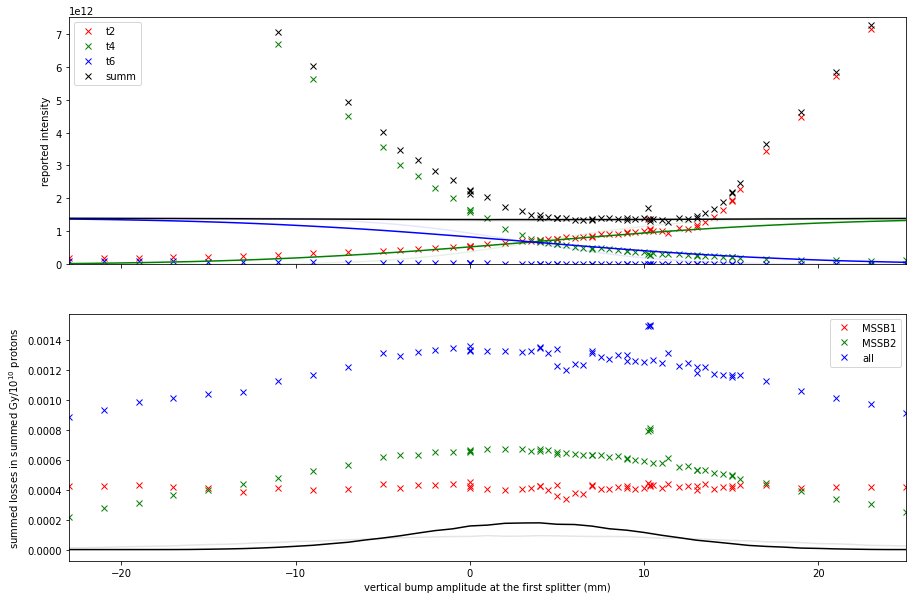

In [293]:
fig, axs = plt.subplots(2, 1, figsize=(15, 10), sharex=True)

axs[1].set_xlabel('vertical bump amplitude at the first splitter (mm)')

t2 = 'BSI.230705'
t4 = 'BSI.240610'
t6 = 'BSI.251010'

ax = axs[0]
ax.plot(df_scan['knob mean'], df_scan[t2], 'rx', label='t2')
ax.plot(df_scan['knob mean'], df_scan[t4], 'gx', label='t4')
ax.plot(df_scan['knob mean'], df_scan[t6], 'bx', label='t6')
ax.plot(df_scan['knob mean'], df_scan[t2]+df_scan[t4]+df_scan[t6], 'kx', label='summ')
ax.legend()
ax.set_ylabel('reported intensity')

df_model = pd.read_pickle('efficiency_positions_y.pckl')
# ax = ax.twinx()
Vscale, Xoffset = 14e11, 3
ax.plot(df_model['positions']*1e3+Xoffset, df_model['nominal top']*Vscale, 'g-')
ax.plot(df_model['positions']*1e3+Xoffset, df_model['nominal bottom']*Vscale, 'b-')
ax.plot(df_model['positions']*1e3+Xoffset, (1-df_model['nominal lost'])*Vscale, 'k-')

ax.plot(df_model['positions']*1e3+Xoffset, df_model['smallerV top']*Vscale, 'g-', alpha=0.1)
ax.plot(df_model['positions']*1e3+Xoffset, df_model['smallerV bottom']*Vscale, 'b-', alpha=0.1)
ax.plot(df_model['positions']*1e3+Xoffset, (1-df_model['smallerV lost'])*Vscale, 'k-', alpha=0.1)
ax.set_ylim(0, 15e11*5)

ax.set_xlim(df_scan['knob mean'].min(), df_scan['knob mean'].max())


ax = axs[1]
ax.set_ylabel('summed losses in summed Gy/10$^{10}$ protons')
ax.plot(df_scan['knob mean'], df_scan['blms MSSB1']/df_scan['intensity E10'], 'rx', label='MSSB1')
ax.plot(df_scan['knob mean'], df_scan['blms MSSB2']/df_scan['intensity E10'], 'gx', label='MSSB2')
ax.plot(df_scan['knob mean'], df_scan['blms']/df_scan['intensity E10'], 'bx', label='all')
ax.legend()

df_model = pd.read_pickle('efficiency_positions_y.pckl')
# ax = ax.twinx()
Vscale= 0.003
ax.plot(df_model['positions']*1e3+Xoffset, (df_model['smallerV lost'])*Vscale, 'k-')


ax.plot(df_model['positions']*1e3+Xoffset, (df_model['nominal lost'])*Vscale, 'k-', alpha=0.1)


ax.set_xlim(df_scan['knob mean'].min(), df_scan['knob mean'].max())

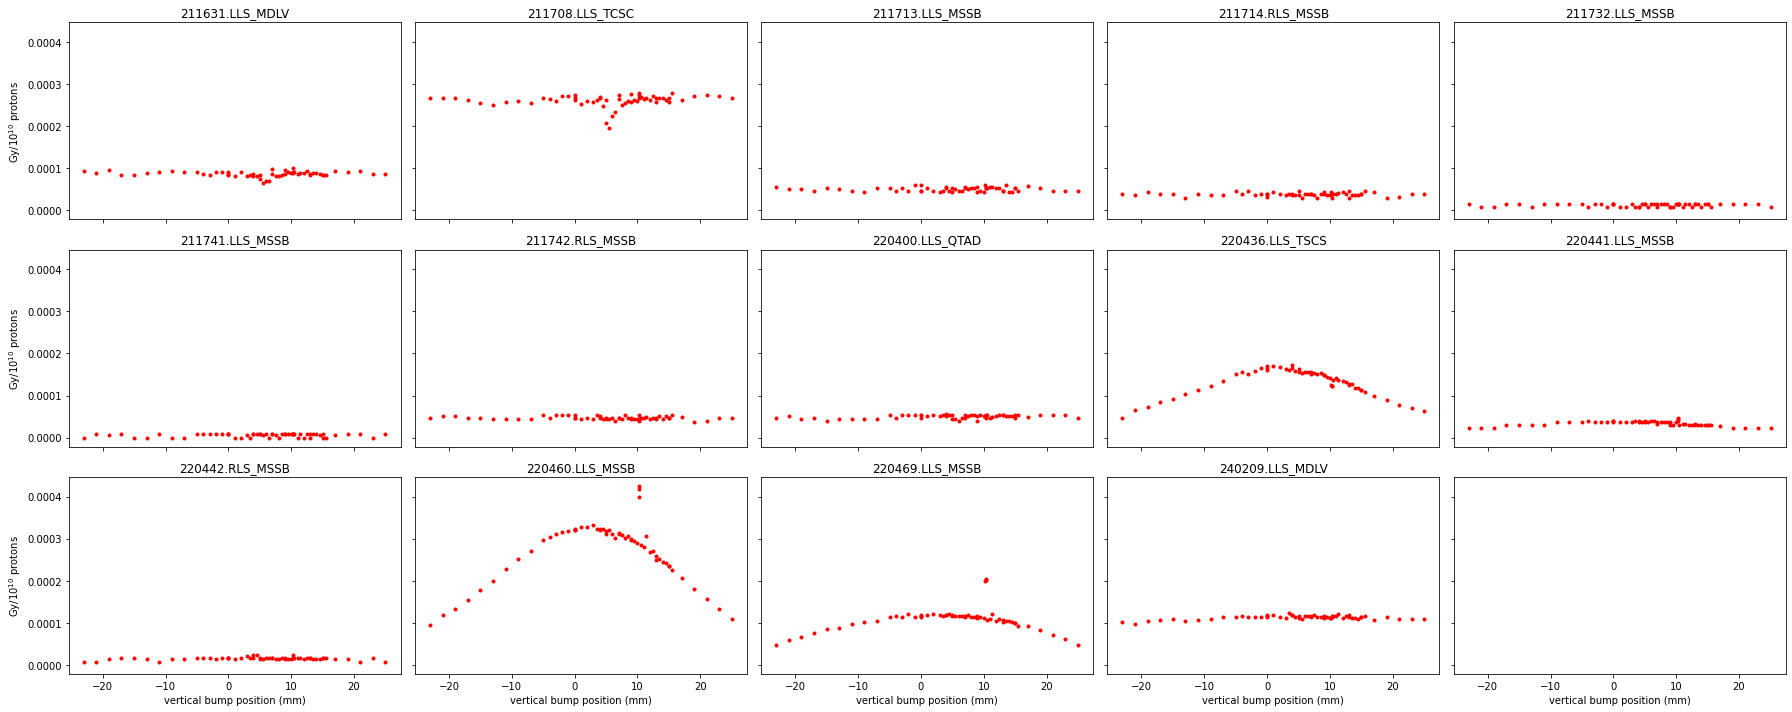

In [51]:
blms = [col for col in df_scan.columns if 'BLM' in col]
blms.sort()

fig, axs = plt.subplots(3, 5, figsize=(25, 10), sharex=True, sharey=True, tight_layout=True)

for ax, blm in zip(axs.flatten(), blms):
    ax.set_title(blm.replace('BLM ', ''))
    
    ax.plot(df_scan['knob mean'], df_scan[blm]/df_scan['intensity E10'], 'r.')

for ax in axs[:, 0]:
    ax.set_ylabel('Gy/10$^{10}$ protons')
for ax in axs[-1, :]:
    ax.set_xlabel('vertical bump position (mm)')


## 25/08

BSI calibration

In [222]:
all_data = all_data_all_time


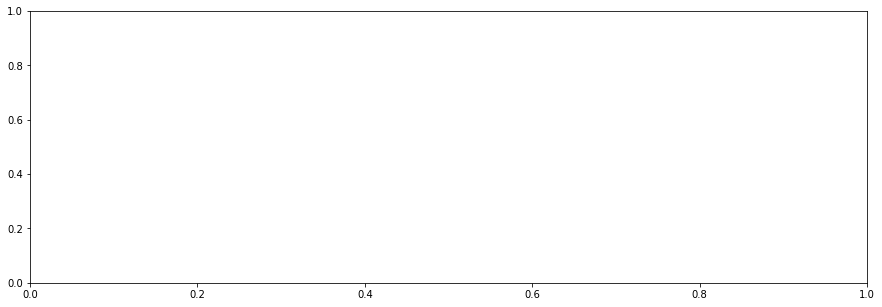

In [223]:
fig_all, ax_all = plt.subplots(figsize=(15, 5))

### T2 BSI calibration

0.7321188090191143 0.010236212221496274


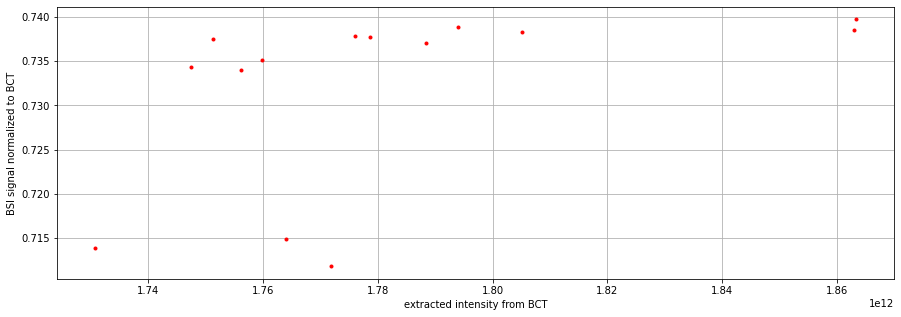

In [224]:
t2 = 'BSI.230705'
t4 = 'BSI.240610'
t6 = 'BSI.251010'
tt22 = 'BSIA.220412'

df = all_data[all_data['selector']=='SPS.USER.SFTPRO2']

df = df[df[t6]/df['intensity E10']*1e-10<0.05]
df = df[df[t4]/df['intensity E10']*1e-10<0.05]


fig, ax  = plt.subplots(figsize=(15, 5))


df = df[df['intensity E10'] > 10]
df = df[df[t2]/df['intensity E10']*1e-10>0.6]

ax.plot(df['intensity E10']*1e10, df[t2]/df['intensity E10']*1e-10, 'r.')
ax_all.plot(df['intensity E10']*1e10, df[t2]/df['intensity E10']*1e-10, 'r.', label='t2', markersize=10, alpha=0.5)


# ax.set_xlim(0, ax.get_xlim()[1]*1.1)
# ax.set_ylim(ax.get_ylim()[0]*0.9, ax.get_ylim()[1]*1.1)

ax.grid(True)

ax.set_xlabel('extracted intensity from BCT')
ax.set_ylabel('BSI signal normalized to BCT')

# printed_bsis = ['BSI.230705', 'BSI.240610', 'BSI.251010', 'BSIA.220412']
# print((' {:>15s}'*len(printed_bsis)).format(*printed_bsis))
# for index, row in df.iterrows():
#     elem = row
#     print((' {:15.2e}'*len(printed_bsis)).format(*elem[printed_bsis]/elem['intensity E10']*1e-10))


print((df[t2]/df['intensity E10']*1e-10).mean(), (df[t2]/df['intensity E10']*1e-10).std())


### T4

0.7993379948833902 0.038938111057529805


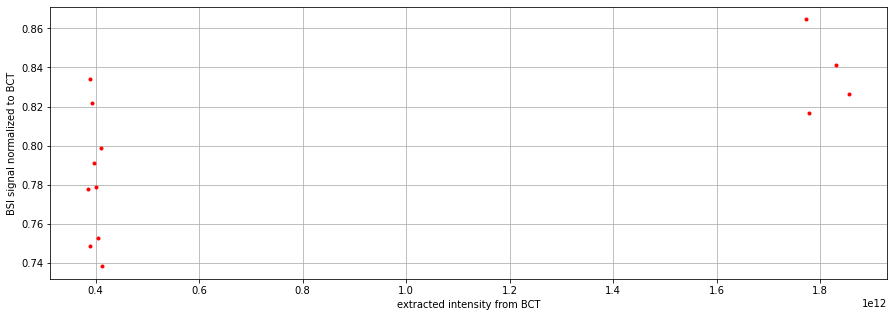

In [225]:
t2 = 'BSI.230705'
t4 = 'BSI.240610'
t6 = 'BSI.251010'
tt22 = 'BSIA.220412'

df = all_data[all_data['selector']=='SPS.USER.SFTPRO2']

df = df[df[t6]/df['intensity E10']*1e-10<0.05]
df = df[df[t2]/df['intensity E10']*1e-10<0.05]


fig, ax  = plt.subplots(figsize=(15, 5))


df = df[df['intensity E10'] > 10]
df = df[df[t4]/df['intensity E10']*1e-10>0.6]
df = df[df[t4]/df['intensity E10']*1e-10<1.1]

ax.plot(df['intensity E10']*1e10, df[t4]/df['intensity E10']*1e-10, 'r.')
ax_all.plot(df['intensity E10']*1e10, df[t4]/df['intensity E10']*1e-10, 'g.', label='t4', markersize=10, alpha=0.5)


# ax.set_xlim(0, ax.get_xlim()[1]*1.1)
# ax.set_ylim(ax.get_ylim()[0]*0.9, ax.get_ylim()[1]*1.1)

ax.grid(True)

ax.set_xlabel('extracted intensity from BCT')
ax.set_ylabel('BSI signal normalized to BCT')

# printed_bsis = ['BSI.230705', 'BSI.240610', 'BSI.251010', 'BSIA.220412']
# print((' {:>15s}'*len(printed_bsis)).format(*printed_bsis))
# for index, row in df.iterrows():
#     elem = row
#     print((' {:15.2e}'*(len(printed_bsis)+1)).format(*elem[printed_bsis]/elem['intensity E10']*1e-10, elem['blms']))
print((df[t4]/df['intensity E10']*1e-10).mean(), (df[t4]/df['intensity E10']*1e-10).std())


### t6 calibration

0.7917724580858556 0.053025321363605694


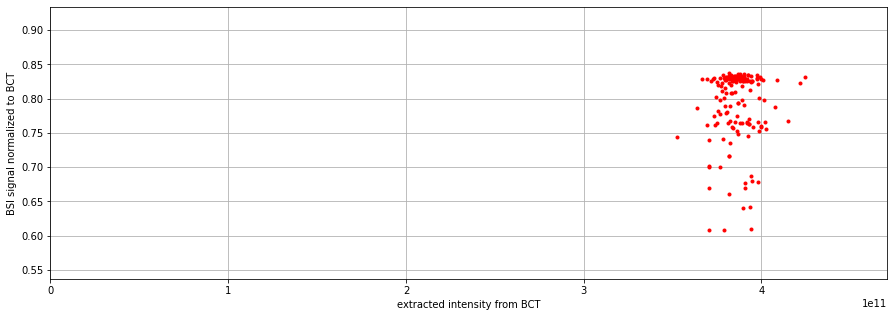

In [226]:
t2 = 'BSI.230705'
t4 = 'BSI.240610'
t6 = 'BSI.251010'
tt22 = 'BSIA.220412'

df = all_data[all_data['selector']=='SPS.USER.SFTPRO2']

df = df[df[t4]/df['intensity E10']*1e-10<0.05]
df = df[df[t2]/df['intensity E10']*1e-10<0.05]
df = df[df[t6]/df['intensity E10']*1e-10>0.2]


fig, ax  = plt.subplots(figsize=(15, 5))


df = df[df['intensity E10'] > 10]
df = df[df[t6]/df['intensity E10']*1e-10>0.6]
# df = df[df['blms']/df['intensity E10']*1e-10<10e-10]

ax.plot(df['intensity E10']*1e10, df[t6]/df['intensity E10']*1e-10, 'r.')
ax_all.plot(df['intensity E10']*1e10, df[t6]/df['intensity E10']*1e-10, 'b.', label='t6', zorder=-1, markersize=10, alpha=0.5)


ax.set_xlim(0, ax.get_xlim()[1]*1.1)
ax.set_ylim(ax.get_ylim()[0]*0.9, ax.get_ylim()[1]*1.1)

ax.grid(True)

ax.set_xlabel('extracted intensity from BCT')
ax.set_ylabel('BSI signal normalized to BCT')

# printed_bsis = ['BSI.230705', 'BSI.240610', 'BSI.251010', 'BSIA.220412']
# print((' {:>15s}'*len(printed_bsis)).format(*printed_bsis))
# for index, row in df.iterrows():
#     elem = row
#     print((' {:15.2e}'*(len(printed_bsis)+1)).format(*elem[printed_bsis]/elem['intensity E10']*1e-10, elem['blms']/elem['intensity E10']*1e-10))
print((df[t6]/df['intensity E10']*1e-10).mean(), (df[t6]/df['intensity E10']*1e-10).std())

    

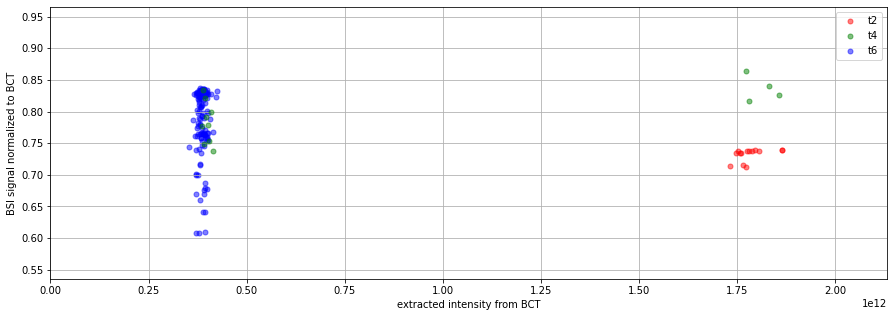

In [227]:
ax = ax_all
ax.set_xlim(0, ax.get_xlim()[1]*1.1)
ax.set_ylim(ax.get_ylim()[0]*0.9, ax.get_ylim()[1]*1.1)

ax.grid(True)

ax.set_xlabel('extracted intensity from BCT')
ax.set_ylabel('BSI signal normalized to BCT')
ax.legend()

fig_all

Text(0.5, 0, 'vertical position (mm)')

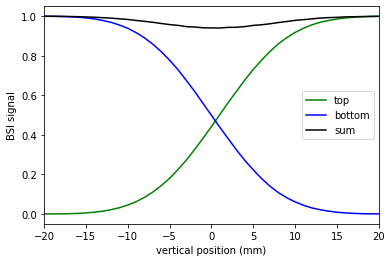

In [238]:
fig, ax = plt.subplots()
df_model = pd.read_pickle('efficiency_positions_y.pckl')
Xoffset = 0
ax.plot(df_model['positions']*1e3+Xoffset, df_model['smallerV top'], 'g-', label='top')
ax.plot(df_model['positions']*1e3+Xoffset, df_model['smallerV bottom'], 'b-', label='bottom')
ax.plot(df_model['positions']*1e3+Xoffset, (1-df_model['smallerV lost']), 'k-', label='sum')

ax.set_xlim(-20, 20)
ax.legend()
ax.set_ylabel('BSI signal')
ax.set_xlabel('vertical position (mm)')


Text(0.5, 0, 'horizontal position (mm) position')

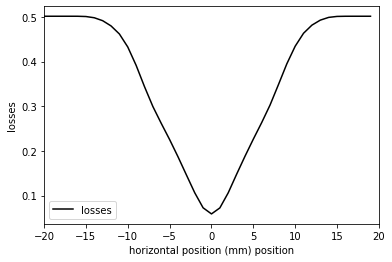

In [239]:
fig, ax = plt.subplots()
df_model = pd.read_pickle('efficiency_positions_x.pckl')
Xoffset = 0
# ax.plot(df_model['positions']*1e3+Xoffset, df_model['smallerV top'], 'g-', label='top')
# ax.plot(df_model['positions']*1e3+Xoffset, df_model['smallerV bottom'], 'b-', label='bottom')
ax.plot(df_model['positions']*1e3, df_model['smallerV lost'], 'k-', label='losses')

ax.set_xlim(-20, 20)
ax.legend()
ax.set_ylabel('losses')
ax.set_xlabel('horizontal position (mm) position')


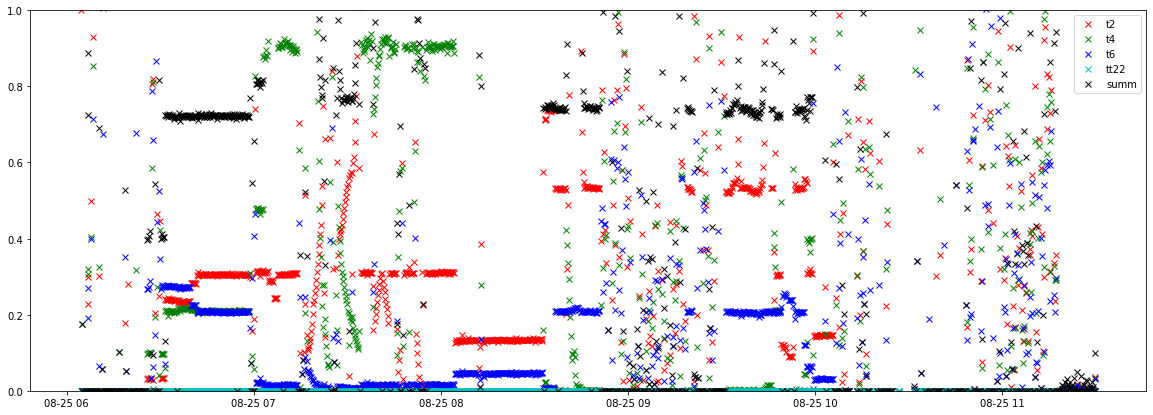

In [69]:
fig, ax = plt.subplots(figsize=(20, 7))

df = all_data[all_data['selector']=='SPS.USER.SFTPRO2'].between_time('6:00', '11:30')

t2 = 'BSI.230705'
t4 = 'BSI.240610'
t6 = 'BSI.251010'
tt22 = 'BSIA.220412'


ax.plot(df.index, df[t2]/df['intensity E10']*1e-10, 'rx', label='t2')
ax.plot(df.index, df[t4]/df['intensity E10']*1e-10, 'gx', label='t4')
ax.plot(df.index, df[t6]/df['intensity E10']*1e-10, 'bx', label='t6')
ax.plot(df.index, df[tt22]/df['intensity E10']*1e-10, 'cx', label='tt22')
ax.plot(df.index, (df[t2]+df[t4]+df[t6])//df['intensity E10']*1e-10, 'kx', label='summ')

ax.set_ylim(0, 1)
ax.legend()

(0.0, 1.0)

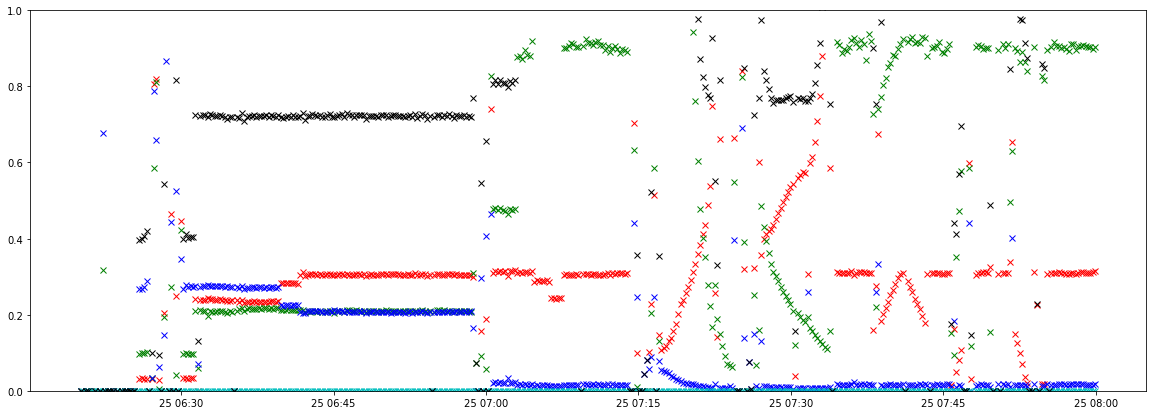

In [68]:
fig, ax = plt.subplots(figsize=(20, 7))

df = all_data[all_data['selector']=='SPS.USER.SFTPRO2'].between_time('6:20', '8:00')

t2 = 'BSI.230705'
t4 = 'BSI.240610'
t6 = 'BSI.251010'
tt22 = 'BSIA.220412'


ax.plot(df.index, df[t2]/df['intensity E10']*1e-10, 'rx', label='t2')
ax.plot(df.index, df[t4]/df['intensity E10']*1e-10, 'gx', label='t4')
ax.plot(df.index, df[t6]/df['intensity E10']*1e-10, 'bx', label='t6')
ax.plot(df.index, df[tt22]/df['intensity E10']*1e-10, 'cx', label='tt22')
ax.plot(df.index, (df[t2]+df[t4]+df[t6])//df['intensity E10']*1e-10, 'kx', label='summ')

ax.set_ylim(0, 1)


(0.0, 1.0)

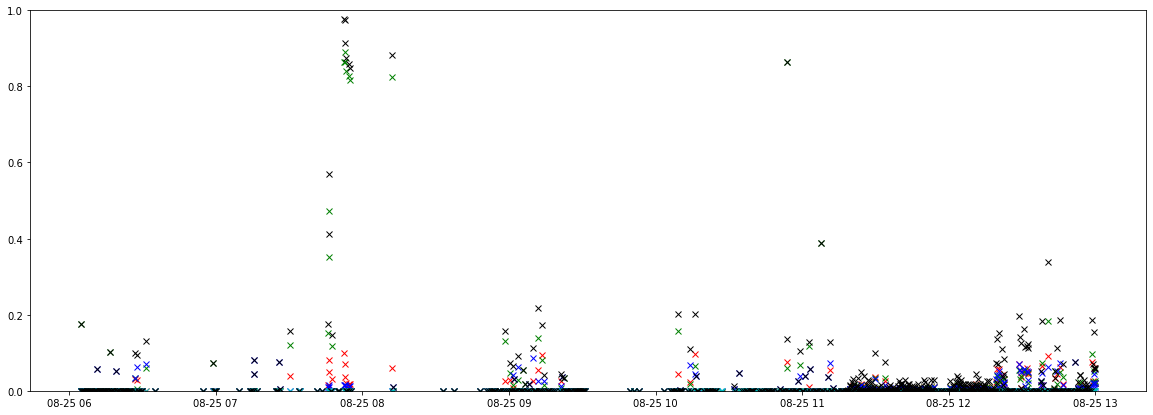

In [72]:
fig, ax = plt.subplots(figsize=(20, 7))

df = all_data[all_data['selector']=='SPS.USER.SFTPRO2']

df = df[df[t6]/df['intensity E10']*1e-10<0.1]
df = df[df[t2]/df['intensity E10']*1e-10<0.1]

t2 = 'BSI.230705'
t4 = 'BSI.240610'
t6 = 'BSI.251010'
tt22 = 'BSIA.220412'


ax.plot(df.index, df[t2]/df['intensity E10']*1e-10, 'rx', label='t2')
ax.plot(df.index, df[t4]/df['intensity E10']*1e-10, 'gx', label='t4')
ax.plot(df.index, df[t6]/df['intensity E10']*1e-10, 'bx', label='t6')
ax.plot(df.index, df[tt22]/df['intensity E10']*1e-10, 'cx', label='tt22')
ax.plot(df.index, (df[t2]+df[t4]+df[t6])//df['intensity E10']*1e-10, 'kx', label='summ')

ax.set_ylim(0, 1)


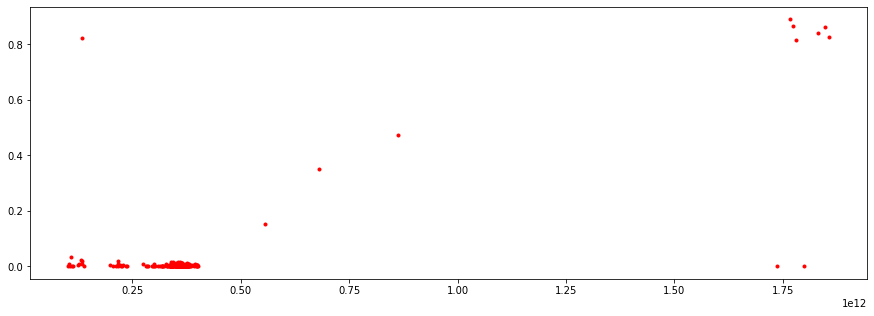

In [91]:
all_data = all_data_all_time.loc['2021-08-25']


t2 = 'BSI.230705'
t4 = 'BSI.240610'
t6 = 'BSI.251010'
tt22 = 'BSIA.220412'

df = all_data[all_data['selector']=='SPS.USER.SFTPRO2']

df = df[df[t6]/df['intensity E10']*1e-10<0.1]
df = df[df[t2]/df['intensity E10']*1e-10<0.1]


fig, ax  = plt.subplots(figsize=(15, 5))


df = df[df['intensity E10'] > 10]

ax.plot(df['intensity E10']*1e10, df[t4]/df['intensity E10']*1e-10, 'r.')

      BSI.230705      BSI.240610      BSI.251010     BSIA.220412
        7.15e-01        2.32e-02        7.57e-03        4.25e-11
        7.12e-01        2.09e-02        6.75e-03        4.43e-11
        7.14e-01        2.18e-02        7.28e-03        4.39e-11
        7.38e-01        4.88e-03        7.80e-03        4.45e-11
        7.37e-01        3.14e-03        7.23e-03        4.50e-11
        7.39e-01        4.58e-03        7.55e-03        4.50e-11
        7.35e-01        2.15e-03        6.34e-03        4.42e-11
        7.38e-01        3.66e-03        7.11e-03        4.39e-11
        7.34e-01        1.51e-03        5.72e-03        4.43e-11
        7.39e-01        3.91e-03        7.52e-03        4.46e-11
        7.38e-01        3.57e-03        7.45e-03        4.44e-11
        7.40e-01        6.48e-03        9.70e-03        4.48e-11
        7.34e-01        1.87e-03        4.99e-03        4.47e-11
        7.38e-01        4.19e-03        7.96e-03        4.44e-11


In [98]:
elem1=df[(df['intensity E10']>1.5) & ( df[t4]>0.6)].iloc[0]
ax.scatter(elem1['intensity E10']*1e10, elem1[t4]/elem1['intensity E10']*1e-10, marker = 'x', color='g',linewidth=5, s=500)


elem2=df[(df['intensity E10']>150) & ( df[t4]>0.6)].iloc[-1]
ax.scatter(elem2['intensity E10']*1e10, elem2[t4]/elem2['intensity E10']*1e-10, marker = 'x', color='b',linewidth=5, s=500)


In [99]:
elem

cyclestamp          selector  intensity E10  \
time                                                                            
2021-08-18 08:31:12.135  1629275472135000000  SPS.USER.SFTPRO2      39.022312   
2021-08-18 08:32:14.535  1629275534535000000  SPS.USER.SFTPRO2      40.105244   
2021-08-18 08:32:45.735  1629275565735000000  SPS.USER.SFTPRO2      39.397648   
2021-08-18 08:33:48.135  1629275628135000000  SPS.USER.SFTPRO2      40.148315   
2021-08-18 08:34:19.335  1629275659335000000  SPS.USER.SFTPRO2      38.351639   
2021-08-18 08:34:50.535  1629275690535000000  SPS.USER.SFTPRO2      38.566994   
2021-08-18 08:35:21.735  1629275721735000000  SPS.USER.SFTPRO2      38.099365   
2021-08-18 08:35:52.935  1629275752935000000  SPS.USER.SFTPRO2      38.868492   
2021-08-18 08:36:24.135  1629275784135000000  SPS.USER.SFTPRO2      39.797592   
2021-08-18 08:36:55.335  1629275815335000000  SPS.USER.SFTPRO2      38.640831   
2021-08-18 08:37:57.735  1629275877735000000  SPS.USER.SFTPRO2      39.723755   
2021-08-18 08:38:28.935  1629275908935000000  SPS.USER.SFTPRO2      38.893101   
2021-08-18 12:26:22.935  1629289582935000000  SPS.USER.SFTPRO2      41.323536   
2021-08-18 12:26:48.135  1629289608135000000  SPS.USER.SFTPRO2      40.382130   
2021-08-18 12:27:38.535  1629289658535000000  SPS.USER.SFTPRO2      40.997425   
2021-08-18 15:17:19.335  1629299839335000000  SPS.USER.SFTPRO2      41.132790   
2021-08-18 15:17:44.535  1629299864535000000  SPS.USER.SFTPRO2      40.019104   
2021-08-18 15:46:43.335  1629301603335000000  SPS.USER.SFTPRO2      23.381395   
2021-08-25 07:45:48.135  1629877548135000000  SPS.USER.SFTPRO2      55.631729   
2021-08-25 07:46:16.935  1629877576935000000  SPS.USER.SFTPRO2      68.006248   
2021-08-25 07:53:00.135  1629877980135000000  SPS.USER.SFTPRO2     177.285004   
2021-08-25 07:53:14.535  1629877994535000000  SPS.USER.SFTPRO2     183.151367   
2021-08-25 07:54:40.935  1629878080935000000  SPS.USER.SFTPRO2     185.669174   
2021-08-25 07:54:55.335  1629878095335000000  SPS.USER.SFTPRO2     177.937424   
2021-08-25 10:31:52.935  1629887512935000000  SPS.USER.SFTPRO2      34.401413   
2021-08-25 11:18:40.935  1629890320935000000  SPS.USER.SFTPRO2      38.628525   
2021-08-25 11:19:24.135  1629890364135000000  SPS.USER.SFTPRO2      37.287170   
2021-08-25 11:19:38.535  1629890378535000000  SPS.USER.SFTPRO2      36.099644   
2021-08-25 11:20:21.735  1629890421735000000  SPS.USER.SFTPRO2      37.890163   
2021-08-25 11:20:50.535  1629890450535000000  SPS.USER.SFTPRO2      34.979797   
2021-08-25 11:21:04.935  1629890464935000000  SPS.USER.SFTPRO2      34.665993   
2021-08-25 11:21:19.335  1629890479335000000  SPS.USER.SFTPRO2      35.927357   
2021-08-25 11:21:33.735  1629890493735000000  SPS.USER.SFTPRO2      33.189274   
2021-08-25 11:21:48.135  1629890508135000000  SPS.USER.SFTPRO2      37.434841   
2021-08-25 11:22:16.935  1629890536935000000  SPS.USER.SFTPRO2      34.696758   
2021-08-25 11:22:31.335  1629890551335000000  SPS.USER.SFTPRO2      33.619984   
2021-08-25 11:23:00.135  1629890580135000000  SPS.USER.SFTPRO2      36.173477   
2021-08-25 11:23:28.935  1629890608935000000  SPS.USER.SFTPRO2      40.019100   
2021-08-25 11:23:57.735  1629890637735000000  SPS.USER.SFTPRO2      33.841492   
2021-08-25 11:25:24.135  1629890724135000000  SPS.USER.SFTPRO2      36.167324   
2021-08-25 11:25:38.535  1629890738535000000  SPS.USER.SFTPRO2      36.093487   
2021-08-25 11:26:07.335  1629890767335000000  SPS.USER.SFTPRO2      35.465881   
2021-08-25 11:26:21.735  1629890781735000000  SPS.USER.SFTPRO2      33.872257   
2021-08-25 11:26:50.535  1629890810535000000  SPS.USER.SFTPRO2      36.376526   
2021-08-25 11:27:19.335  1629890839335000000  SPS.USER.SFTPRO2      34.690605   
2021-08-25 11:28:16.935  1629890896935000000  SPS.USER.SFTPRO2      38.868488   
2021-08-25 11:28:45.735  1629890925735000000  SPS.USER.SFTPRO2      34.056847   
2021-08-25 11:29:00.135  1629890940135000000  SPS.USER.SFTPRO2   

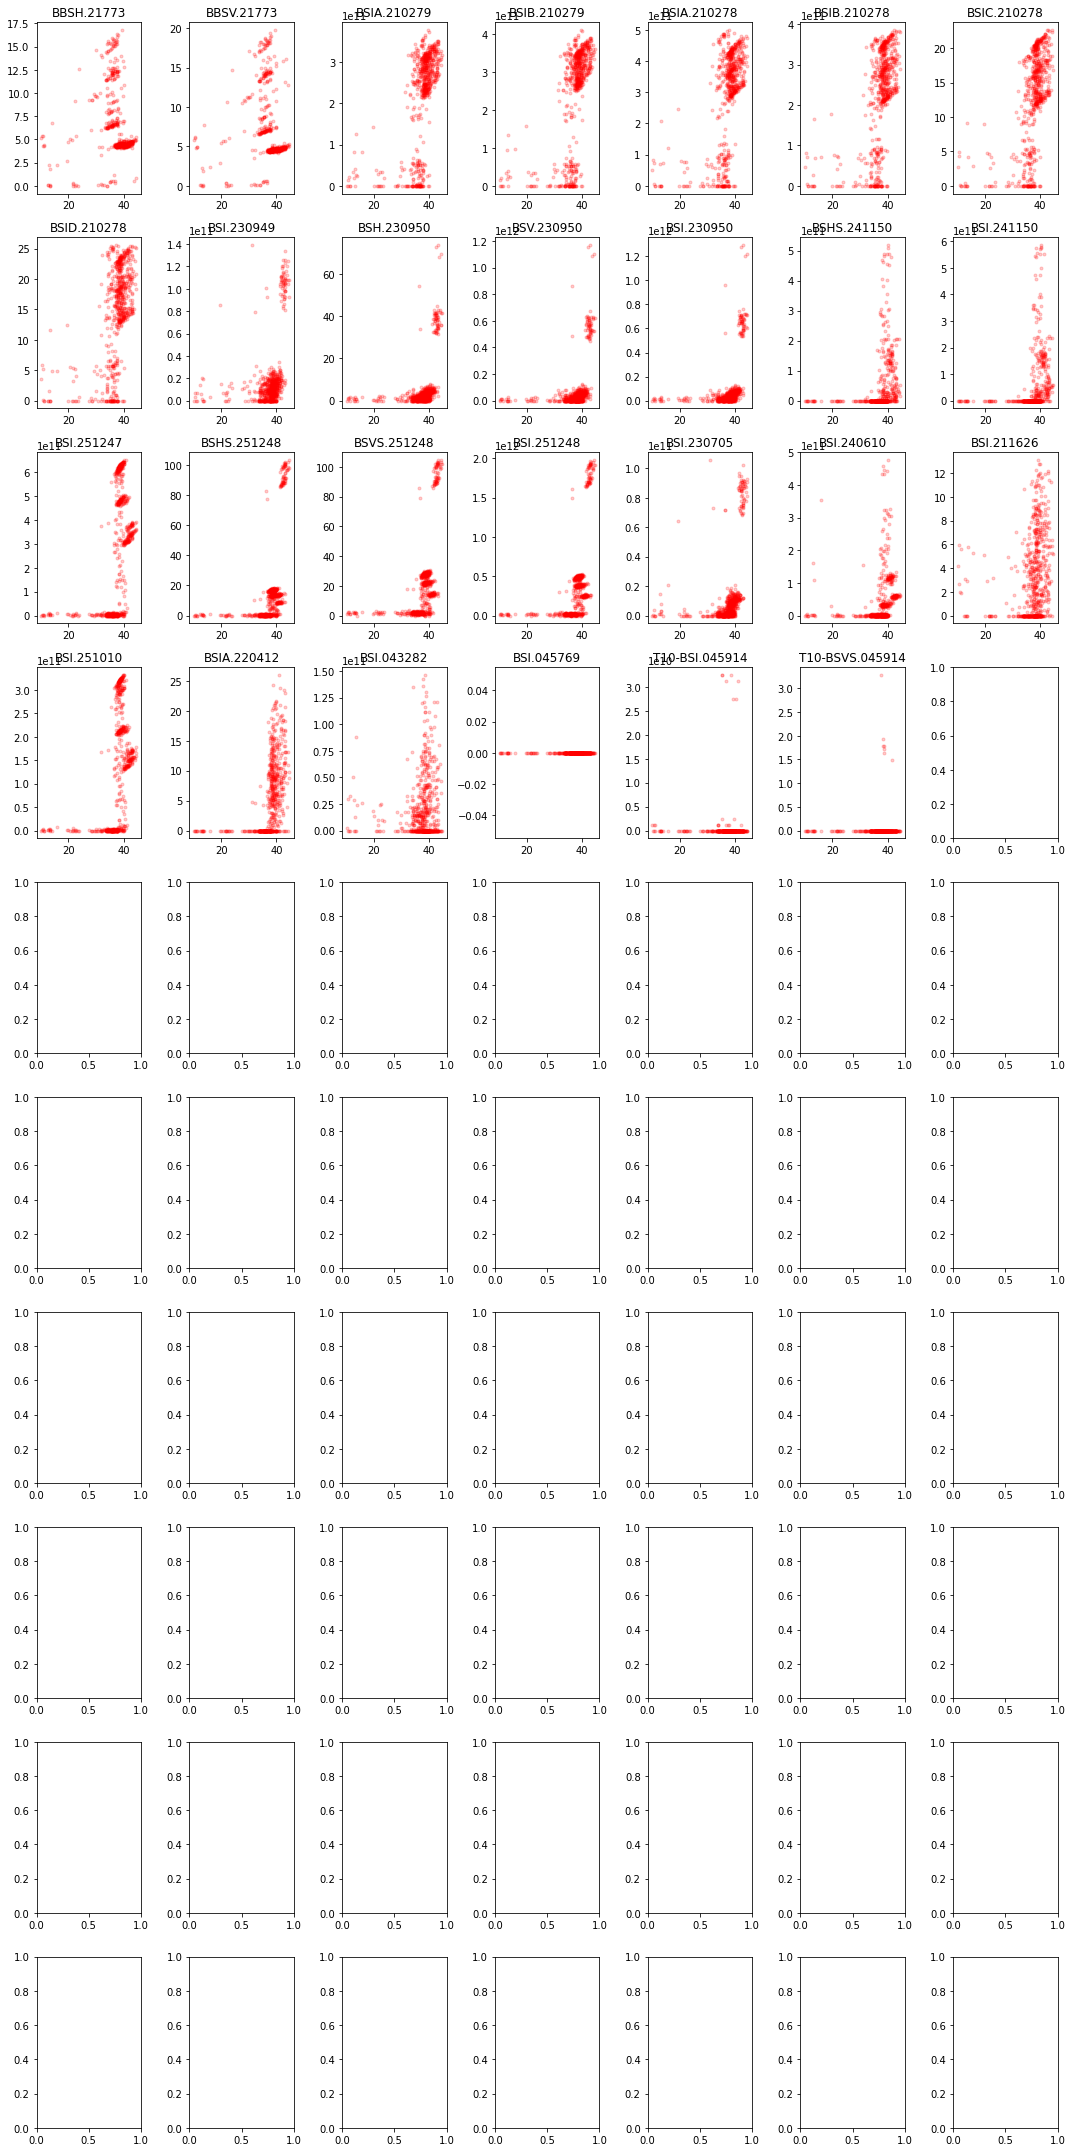

In [153]:
data = all_data[all_data['selector']=='SPS.USER.SFTPRO2']
data = data[data['intensity E10'].between(10, 50)]
data.sort_index(inplace=True)
data = data.between_time('06:00', '13:00')

fig, axs = plt.subplots(10, 7, figsize=(15, 30), tight_layout=True)
axs = axs.flatten()

for ax, bsi_name in zip(axs, working_bsis):
    ax.plot(data['intensity E10'], data[bsi_name], 'r.', alpha=0.2)
#     ax.yaxis.set_visible(False)
#     ax = ax.twinx()
#     ax.plot(data['intensity E10'], data[bsi_name + ' recomputed'], 'b.', alpha=0.1)
#     ax.yaxis.set_visible(False)
    ax.set_title(bsi_name)

In [181]:
df_scan[['knob mean', t2, t4, t6, 'intensity E10']]

knob mean    BSI.230705    BSI.240610    BSI.251010  \
time                                                                           
2021-08-18 12:11:52.935 -14.998889  3.294150e+09  1.233325e+09  3.003805e+11   
2021-08-18 12:12:31.335 -12.999986  1.769139e+09  0.000000e+00  2.969984e+11   
2021-08-18 12:13:09.735 -10.999034  6.645368e+09  2.707607e+09  2.867648e+11   
2021-08-18 12:13:48.135  -9.000351  9.254690e+09  2.133747e+09  2.741430e+11   
2021-08-18 12:14:26.535  -7.001196  1.167378e+10  0.000000e+00  2.596115e+11   
2021-08-18 12:15:04.935  -5.000530  1.852206e+10  4.140673e+09  2.483244e+11   
2021-08-18 12:15:43.335  -3.001244  5.342293e+09  0.000000e+00  2.252877e+11   
2021-08-18 12:16:21.735  -1.000581  1.161037e+10  2.517377e+10  2.228746e+11   
2021-08-18 12:17:00.135   0.000329  1.373461e+10  3.848036e+10  2.055299e+11   
2021-08-18 12:17:38.535   1.000848  1.218740e+10  4.477380e+10  1.711843e+11   
2021-08-18 12:18:16.935   2.002621  1.025340e+10  5.953882e+10  1.803958e+11   
2021-08-18 12:18:55.335   3.001869  1.017096e+10  7.277883e+10  1.522517e+11   
2021-08-18 12:19:33.735   4.004826  6.841939e+09  8.737264e+10  1.390736e+11   
2021-08-18 12:20:12.135   5.004278  1.474283e+09  9.405605e+10  1.165057e+11   
2021-08-18 12:20:50.535   6.006298  8.303540e+09  1.230154e+11  1.137832e+11   
2021-08-18 12:21:28.935   7.006217  1.150574e+10  1.532778e+11  1.002331e+11   
2021-08-18 12:22:07.335   8.005167  8.969345e+09  1.661405e+11  8.481383e+10   
2021-08-18 12:22:45.735   9.004063  1.103334e+10  1.910512e+11  7.298290e+10   
2021-08-18 12:23:24.135  10.002257  1.141063e+10  2.138724e+11  6.076439e+10   
2021-08-18 12:24:02.535  11.002152  9.438579e+09  2.173505e+11  5.024627e+10   
2021-08-18 12:24:40.935  12.000590  1.009170e+10  2.382346e+11  4.169112e+10   
2021-08-18 12:25:19.335  12.997969  9.698560e+09  2.492203e+11  3.538650e+10   
2021-08-18 12:25:57.735  15.057131  1.314172e+10  2.801264e+11  2.488402e+10   
2021-08-18 12:26:22.935  17.054060  1.072263e+10  3.050592e+11  1.278115e+10   
2021-08-18 12:26:48.135  18.934952  1.333195e+10  3.039812e+11  1.021804e+10   
2021-08-18 12:27:38.535  22.697438  1.165793e+10  3.274366e+11  5.829506e+09   
2021-08-18 12:28:28.935  10.006246  7.755043e+09  1.309575e+11  2.246876e+11   
2021-08-18 12:29:19.335   0.000429  1.355072e+10  4.004342e+10  2.143414e+11   
2021-08-18 12:29:44.535   0.000252  1.147721e+10  3.783992e+10  2.091933e+11   
2021-08-18 12:30:09.735  -0.000002  8.341586e+09  3.367388e+10  2.118408e+11   
2021-08-18 12:30:34.935   0.000049  1.023120e+10  3.556033e+10  2.072491e+11   
2021-08-18 12:31:00.135   0.000172  1.446382e+10  4.067117e+10  2.173015e+11   
2021-08-18 12:31:25.335   0.000063  7.885034e+09  2.745653e+10  1.673959e+11   
2021-08-18 12:31:50.535   0.000177  1.033266e+10  3.617858e+10  2.128129e+11   

                         intensity E10  
time                                    
2021-08-18 12:11:52.935      37.650196  
2021-08-18 12:12:31.335      38.087063  
2021-08-18 12:13:09.735      37.502522  
2021-08-18 12:13:48.135      37.077969  
2021-08-18 12:14:26.535      37.034897  
2021-08-18 12:15:04.935      37.077969  
2021-08-18 12:15:43.335      37.047203  
2021-08-18 12:16:21.735      39.822208  
2021-08-18 12:17:00.135      38.776196  
2021-08-18 12:17:38.535      34.198364  
2021-08-18 12:18:16.935      39.114609  
2021-08-18 12:18:55.335      36.893379  
2021-08-18 12:19:33.735      37.847095  
2021-08-18 12:20:12.135      36.524200  
2021-08-18 12:20:50.535      38.413170  
2021-08-18 12:21:28.935      39.508400  
2021-08-18 12:22:07.335      39.182293  
2021-08-18 12:22:45.735      39.748371  
2021-08-18 12:23:24.135      40.308289  
2021-08-18 12:24:02.535      39.120766  
2021-08-18 12:24:40.935      39.822208  
2021-08-18 12:25:19.335      39.951420  
2021-08-18 12:25:57.735      40.431351  
2021-08-18 12:26:22.935      41.323536  
2021-08-18 12:26:48.135      40.382130  
2021-08-18 12:27:38.535      40.99742

<AxesSubplot:xlabel='time'>

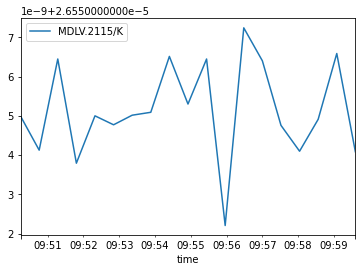

In [29]:
ax.plot(df_scan['knob mean'], df_scan[t2], 'rx', label='t2')
data.between_time('09:50', '14:30').plot(y='MDLV.2115/K')

(-0.0007, 0.0007)

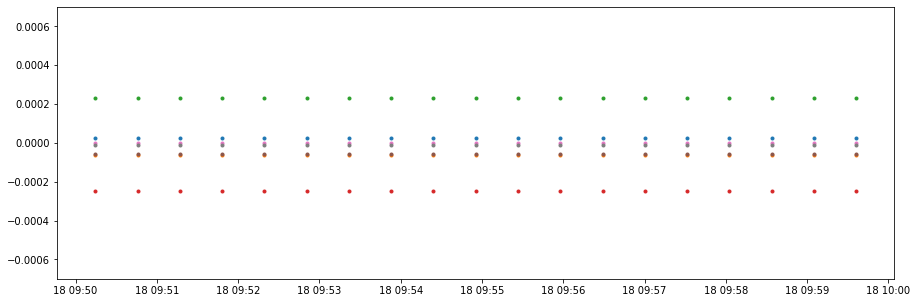

In [51]:
fig, ax = plt.subplots(figsize=(15, 5))

df = data.between_time('09:50', '14:00')

for ps in ['MDLV.2115/K', 'MDLV.2116/K', 'MDLV.2201/K', 'MDLV.2204/K', 'MBE.2103/K', 'MPLS.2115/K', 'MDAH.2201/K', 'MDAH.2303/K']:
    ax.plot(df.index, df[ps], '.', label=ps)
ax.set_ylim(-0.7e-3, 0.7e-3)    

(-0.0007, 0.0007)

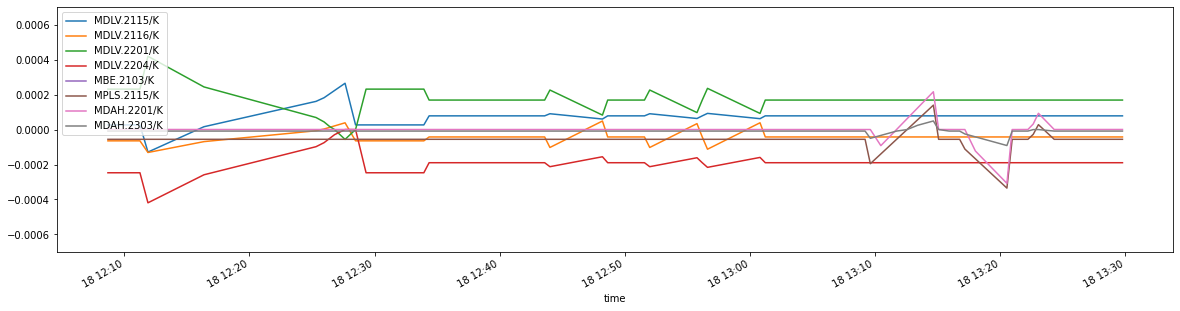

In [101]:
fig, ax = plt.subplots(figsize=(20, 5))

ax  = all_data[all_data['intensity E10'].between(20, 60)].between_time('12:00', '13:30').plot(
    y=['MDLV.2115/K', 'MDLV.2116/K', 'MDLV.2201/K', 'MDLV.2204/K', 'MBE.2103/K',
       'MPLS.2115/K', 'MDAH.2201/K', 'MDAH.2303/K'],
    ax=ax)
ax.set_ylim(-0.7e-3, 0.7e-3)

<AxesSubplot:xlabel='time'>

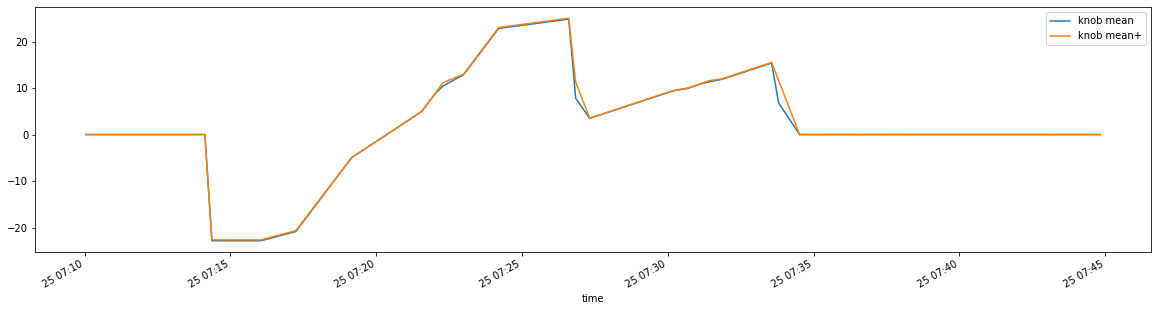

In [193]:
fig, ax = plt.subplots(figsize=(20, 5))
t1, t2 = '7:10', '7:12'
k_names = ['MDLV.2115/K', 'MDLV.2116/K', 'MDLV.2201/K', 'MDLV.2204/K', 'MBB.2113/K', 'MPLS.2115/K', 'MDAH.2201/K', 'MDAH.2303/K', 'MDAV.2301/K', 'MDAV.2305/K']
default_strength = all_data[k_names].between_time(t1, t2).mean().to_dict()
all_data[k_names].between_time(t1, t2).std()


knob = { #position bump, +1mm in vertical smaller beam  
    'MDLV.2201/K': 12.47e-6,
    'MDLV.2204/K': -11.46e-6,
    'MDAV.2301/K': -5.87e-6,
#     'MDAV.2305/K': 5.87e-6,
    }
    


def knob_values(row, knob):
    knob_values = []
    for key in knob:
        val = (row[key]-default_strength[key])/knob[key]
        knob_values.append(val)
    knob_values = np.array(knob_values)
    return knob_values, knob_values.mean(), knob_values.std()

all_data[['knob', 'knob mean', 'knob std']] = all_data[k_names].apply(lambda row: knob_values(row, knob), axis=1, result_type='expand')
all_data['knob mean+'] = all_data['knob mean']+all_data['knob std']

df_scan =  all_data[all_data['intensity E10'].between(20, 200)].between_time('7:10', '7:45')

df_scan.plot(ax=ax, y=['knob mean', 'knob mean+'])

# ax  = all_data[all_data['intensity E10'].between(20, 60)].between_time('12:00', '13:30').plot(
#     y=['MDLV.2115/K'],
#     ax=ax)
# ax.set_ylim(-0.2e-3, 0.2e-3)

In [ ]:
df_test = all_data[all_data['intensity E10'].between(20, 200)].between_time('6:40', '8:00')

<AxesSubplot:xlabel='time'>

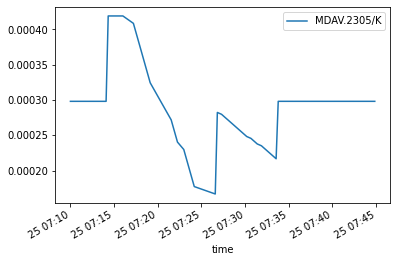

In [186]:
df_scan.plot(y='MDAV.2305/K')

<AxesSubplot:xlabel='time'>

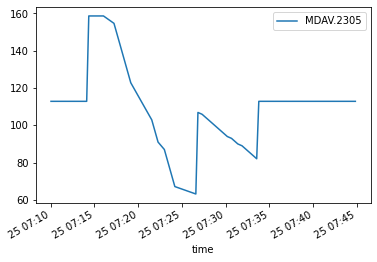

In [187]:
df_scan.plot(y='MDAV.2305')

(0.0, 100.0)

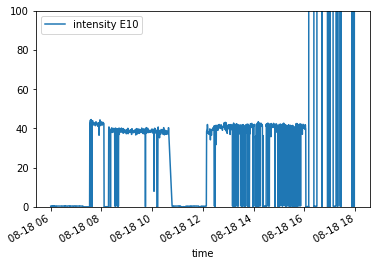

In [387]:
ax = all_data.plot(x= y='intensity E10')
ax.set_ylim(0, 100)